# Market Analyzer

Using Forex Market


**Resources:**

- https://github.com/maghdam/AlphaFlow-MT5-ML-DL-Trading-Lab

- https://github.com/joshyattridge/smart-money-concepts/

- https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter/

- https://github.com/freqtrade/freqtrade-strategies/


Trend Detection

Trend Continuation

Trend Reversal

Sniper Entry

Pattern


In [65]:
import sys
import os
from pathlib import Path
from typing import Optional, List, Union
import warnings
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import logging

np.random.seed(100)

# Configure logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

# ---------------------------------------------------------------------------
# 1) SET PROJECT ROOT AND UPDATE PATH/WORKING DIRECTORY
# ---------------------------------------------------------------------------
project_root = Path.cwd().parent.parent 
print(project_root)
sys.path.append(str(project_root))
os.chdir(str(project_root))
warnings.filterwarnings("ignore")


c:\Users\hp\Desktop\Samuel\ml_orderflow


In [66]:
def connect_mt5(mt5_account_id: Optional[int] = None, mt5_password: Optional[str] = None, mt5_server: Optional[str] = None, **kwargs):
    """
    Initializes the MetaTrader 5 connection and attempts to log in with the provided credentials.
    """
    # Initialize MetaTrader 5 connection
    if not mt5.initialize():
        logger.error(f"initialize() failed, error code = {mt5.last_error()}")
        return False
    logger.info(f"MT5 Initialized. Version: {mt5.version()}")

    if mt5_account_id and mt5_password and mt5_server:
        authorized = mt5.login(int(mt5_account_id), password=str(mt5_password), server=str(mt5_server), **kwargs)
        if not authorized:
            logger.error(f"MT5 Login failed for account #{mt5_account_id}, error code: {mt5.last_error()}")
            mt5.shutdown()
            return False
    return True

if not mt5.initialize():
    print("Failed to initialize MT5")

## Data

In [67]:
from data.data_loader import get_exchange_symbols

# group = "*Index*"
# group = "*DXY*"
group = ""
cfds_symbols = get_exchange_symbols(group=group)
if cfds_symbols:
    print(f"[{len(cfds_symbols)}] Available symbols on MT5: {cfds_symbols[:20]}...")
else:
    print(f"Could not fetch symbols from MT5")

[400] Available symbols on MT5: ['USDRUB', 'USDAED', 'USDAMD', 'USDARS', 'USDAZN', 'USDBDT', 'USDBGN', 'USDBHD', 'USDBND', 'USDBRL', 'USDCLP', 'USDCNY', 'USDCOP', 'USDDZD', 'USDEGP', 'USDGEL', 'USDGHS', 'USDIDR', 'USDINR', 'USDISK']...


In [68]:
def filter_crypto_pairs(symbols: list) -> list:
    """
    Filters out symbols that are stablecoin-based pairs (e.g., USDC/USDT)
    or FX-based pairs (e.g., EUR/USDT).

    Args:
        symbols: A list of trading pair symbols (e.g., ['BTC/USDT', 'USDC/USDT', 'EUR/USDT']).

    Returns:
        A list of filtered symbols.
    """
    crypto_currencies = ['BTC', 'ETH', 'SOL', 'AAVE', 'DOGE', 'LINK', 'HBAR']

    # Create a list of quotes to filter out
    quotes_to_filter = crypto_currencies

    # Filter out symbols where either base or quote is in the filter list
    # Assuming symbols are in 'BASEQUOTE' 
    filtered_symbols = []
    for symbol in symbols:
        # Split the symbol to get base and quote
        parts = [symbol[:3], symbol[3:]]
        if len(parts) < 2:
            # Skip if not in expected format
            continue

        base = parts[0]
        quote = parts[1]
        # Check if either base or quote is in the filter list
        if base not in quotes_to_filter and quote not in quotes_to_filter:
            filtered_symbols.append(symbol)

    return filtered_symbols


# # To apply to your fetched symbols (e.g., cfds_symbols):
# if 'cfds_symbols' in locals() and cfds_symbols:
#     filtered_cfds_symbols = filter_crypto_pairs(cfds_symbols)
#     print(f"\nFiltered CFD Symbols ({len(filtered_cfds_symbols)}): {filtered_cfds_symbols[:20]}...")
# else:
#     print("\n'cfds_symbols' not found or is empty. Cannot filter.")


In [69]:
# # remove stablecoins and fx-based pairs
# # usdc/usdt, usdt/usdc, eur, gbp, jpy, cad, aud

# def filter_stablecoin_and_fx_pairs(symbols: list) -> list:
#     """
#     Filters out symbols that are stablecoin-based pairs (e.g., USDC/USDT)
#     or FX-based pairs (e.g., EUR/USDT).

#     Args:
#         symbols: A list of trading pair symbols (e.g., ['BTC/USDT', 'USDC/USDT', 'EUR/USDT']).

#     Returns:
#         A list of filtered symbols.
#     """
#     stocks = [
#     'AAL',
#  'AAPL',
#  'ADS',
#  'ABNB',
#  'AIG',
#  'AMD',
#  'AMZN',
#  'BA',
#  'BABA',
#  'BAC',
#  'AIR',
#  'AIRF',
#  'BAY',
#  'BMW',
#  'BIIB',
#  'C',
#  'CRM',
#  'CSCO',
#  'DAL',
#  'CONG',
#  'DBK',
#  'DIS',
#  'EBAY',
#  'FDX',
#  'FOX',
#  'GM',
#  'GOOG',
#  'GS',
#  'HD',
#  'HPQ',
#  'IBM',
#  'INTC',
#  'JNJ',
#  'JPM',
#  'KO',
#  'MA',
#  'MCD',
#  'META',
#  'MRNA',
#  'MSFT',
#  'NFLX',
#  'NKE',
#  'NVDA',
#  'PEP',
#  'PFE',
#  'PG',
#  'PYPL',
#  'SONY',
#  'TEVA',
#  'TSLA',
#  'UBER',
#  'V',
#  'WMT',
#     ]
#     crypto_currencies = ['BTC', 'ETH', 'SOL', 'AAVE']
#     fx_currencies = ['USD', 'EUR', 'GBP', 'JPY', 'CAD', 'AUD', 'CHF', 'BRL', 'XAU', 'XAUT', 'NZD', 'AUD'] # Add more as needed
#     derivatives = ['.conv', '.US', '.OQ', '.N']

#     # Create a list of quotes to filter out
#     quotes_to_filter = stocks + crypto_currencies + fx_currencies + derivatives

#     # Filter out symbols where either base or quote is in the filter list
#     # Assuming symbols are in 'BASEQUOTE' 
#     filtered_symbols = []
#     for symbol in symbols:
#         # Split the symbol to get base and quote
#         parts = [symbol[:3], symbol[3:]]
#         if len(parts) < 2:
#             # Skip if not in expected format
#             continue

#         base = parts[0]
#         quote = parts[1]
#         # Check if either base or quote is in the filter list
#         if base not in quotes_to_filter and quote not in quotes_to_filter:
#             filtered_symbols.append(symbol)

#     return filtered_symbols

# # To apply to your fetched symbols (e.g., cfds_symbols):
# if 'cfds_symbols' in locals() and cfds_symbols:
#     filtered_cfds_symbols = filter_stablecoin_and_fx_pairs(cfds_symbols)
#     print(f"\nFiltered CFD Symbols ({len(filtered_cfds_symbols)}): {filtered_cfds_symbols[:20]}...")
# else:
#     print("\n'cfds_symbols' not found or is empty. Cannot filter.")

In [70]:
# filtered_cfds_symbols

In [71]:
symbols_list = ["DXYm", "EURUSDm", "GBPAUDm", "GBPCADm", "GBPUSDm", "GBPNZDm", 
                "GBPCHFm", "USDJPYm", "USDCADm", "AUDJPYm", "NZDJPYm", 
                "CHFJPYm", "EURCHFm", "EURCADm", "EURAUDm", "EURNZDm",  
                "AUDCADm", "AUDCHFm", "AUDNZDm", "NZDCHFm", "NZDUSDm", 
                "CADCHFm", "EURGBPm", "CADJPYm", "EURJPYm", "USDCHFm",    
                "XAUUSDm", "XAGUSDm", "BTCUSDm", "ETHUSDm", "SOLUSDm"]
filtered_cfds_symbols = [instr for instr in cfds_symbols if instr in symbols_list]

filtered_cfds_symbols

['BTCUSDm',
 'ETHUSDm',
 'SOLUSDm',
 'AUDCADm',
 'AUDCHFm',
 'AUDJPYm',
 'AUDNZDm',
 'CADCHFm',
 'CADJPYm',
 'CHFJPYm',
 'DXYm',
 'EURAUDm',
 'EURCADm',
 'EURCHFm',
 'EURGBPm',
 'EURJPYm',
 'EURNZDm',
 'EURUSDm',
 'GBPAUDm',
 'GBPCADm',
 'GBPCHFm',
 'GBPNZDm',
 'GBPUSDm',
 'NZDCHFm',
 'NZDJPYm',
 'NZDUSDm',
 'USDCADm',
 'USDCHFm',
 'USDJPYm',
 'XAGUSDm',
 'XAUUSDm']

In [72]:
from data.data_loader import get_data_mt5

# Fetch N bars from an earlier period for training
# Volatility 250 (1s) Index, Volatility 75 Index, DXYm
symbol = "DXYm"
N_BARS = 50_000 # 10_000, 50_000
timeframe = mt5.TIMEFRAME_H1 # H1, H4, M15 | try M5 
data = get_data_mt5(symbol=symbol, timeframe=timeframe, n_bars=N_BARS)
data

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2019-03-01 00:00:00,96.195,96.551,96.061,96.460,65853,0,0
2019-03-03 00:00:00,96.455,96.455,96.250,96.366,4086,0,0
2019-03-04 00:00:00,96.367,96.814,96.367,96.646,59563,0,0
2019-03-05 00:00:00,96.647,97.012,96.639,96.861,64026,0,0
2019-03-06 00:00:00,96.861,96.998,96.772,96.824,60656,0,0
...,...,...,...,...,...,...,...
2025-11-12 10:00:00,99.607,99.642,99.565,99.598,1449,31,0
2025-11-12 11:00:00,99.598,99.633,99.536,99.536,1267,31,0
2025-11-12 12:00:00,99.538,99.594,99.522,99.558,1698,31,0


## Linear Regression Channels(LRC)

In [ ]:
import numpy as np
import pandas as pd
from typing import Literal


def linear_regression_channel(
    df: pd.DataFrame,
    src: str = "close",
    period: int = 100,
    devlen: float = 2.0,
    trend_mode: Literal["avg", "vote", "extreme"] = "avg",
    prev_slopes_len: int = 3,
) -> pd.DataFrame:
    """
    Linear Regression Channels for Freqtrade DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain OHLCV columns.
    src : str
        Price source: "open" | "high" | "low" | "close" | "hlc3" | "ohlc4"
    period : int
        Lookback period (default=100)
    devlen : float
        Std multiplier for channels (default=2.0)
    trend_mode : str
        Trend slope comparison mode ("avg", "vote", "extreme")
    prev_slopes_len : int
        Number of previous slopes to evaluate trend momentum

    Returns
    -------
    df : pd.DataFrame
        Original df + regression columns:
        [ 'reg_value', 'reg_upper', 'reg_lower', 'reg_slope', 'reg_degree',
          'reg_intercept', 'reg_r2', 'reg_cfo', 'reg_stdev', 'reg_trend' ]
    """
    # --- choose source price
    if src == "hlc3":
        prices = (df["high"] + df["low"] + df["close"]) / 3.0
    elif src == "ohlc4":
        prices = (df["open"] + df["high"] + df["low"] + df["close"]) / 4.0
    else:
        prices = df[src]

    values, uppers, lowers = [], [], []
    slopes, intercepts, degrees = [], [], []
    stdevs, r2s, cfos, trends = [], [], [], []

    # --- rolling regression
    X = np.arange(1, period + 1).reshape(-1, 1)

    slope_history = []

    for i in range(len(prices)):
        if i < period:
            # not enough data yet
            values.append(np.nan)
            uppers.append(np.nan)
            lowers.append(np.nan)
            slopes.append(np.nan)
            intercepts.append(np.nan)
            degrees.append(np.nan)
            stdevs.append(np.nan)
            r2s.append(np.nan)
            cfos.append(np.nan)
            trends.append("⇒")
            continue

        y = prices.iloc[i - period : i].values

        # precompute regression using closed form
        x_arr = np.arange(1, period + 1, dtype=np.float64)
        y_arr = y.astype(float)

        x_sum = 0.5 * period * (period + 1)
        x2_sum = x_sum * (2 * period + 1) / 3.0
        divisor = period * x2_sum - x_sum * x_sum
        y_sum = np.sum(y_arr)
        xy_sum = np.sum(x_arr * y_arr)

        slope = (period * xy_sum - x_sum * y_sum) / divisor
        intercept = (y_sum * x2_sum - x_sum * xy_sum) / divisor

        # residuals
        residuals = (slope * x_arr + intercept) - y_arr
        res_sum_sq = np.sum(residuals**2)

        # predicted value at last bar
        value = residuals[-1] + y_arr[-1]
        degree = 180.0 / np.pi * np.arctan(slope)
        cfo = 100.0 * residuals[-1] / y_arr[-1] if y_arr[-1] != 0 else 0.0
        stdev = np.sqrt(res_sum_sq / period)

        mean_y = np.mean(y_arr)
        sst = np.sum((y_arr - mean_y) ** 2)
        r2 = 1.0 - res_sum_sq / sst if sst != 0 else -np.inf

        # channels
        upper = value + stdev * devlen
        lower = value - stdev * devlen

        # --- trend detection
        slope_history.append(slope)
        if len(slope_history) > prev_slopes_len:
            slope_history.pop(0)

        if len(slope_history) < prev_slopes_len:
            trend = "⇒"
        else:
            prev_slopes = slope_history[:-1]

            if trend_mode == "avg":
                avg_prev = np.mean(prev_slopes)
                if slope > 0:
                    trend = "⇑" if slope > avg_prev else "⇗"
                elif slope < 0:
                    trend = "⇓" if slope < avg_prev else "⇘"
                else:
                    trend = "⇒"

            elif trend_mode == "vote":
                greater = sum(slope > ps for ps in prev_slopes)
                smaller = sum(slope < ps for ps in prev_slopes)
                if slope > 0:
                    trend = "⇑" if greater > smaller else "⇗"
                elif slope < 0:
                    trend = "⇓" if smaller > greater else "⇘"
                else:
                    trend = "⇒"

            elif trend_mode == "extreme":
                min_slope, max_slope = min(prev_slopes), max(prev_slopes)
                if slope > 0:
                    trend = "⇑" if slope > max_slope else "⇗"
                elif slope < 0:
                    trend = "⇓" if slope < min_slope else "⇘"
                else:
                    trend = "⇒"
            else:
                trend = "⇒"

        # append
        values.append(value)
        uppers.append(upper)
        lowers.append(lower)
        slopes.append(slope)
        intercepts.append(intercept)
        degrees.append(degree)
        stdevs.append(stdev)
        r2s.append(r2)
        cfos.append(cfo)
        trends.append(trend)

    df["reg_value"] = values
    df["reg_upper"] = uppers
    df["reg_lower"] = lowers
    df["reg_slope"] = slopes
    df["reg_intercept"] = intercepts
    df["reg_degree"] = degrees
    df["reg_stdev"] = stdevs
    df["reg_r2"] = r2s
    df["reg_cfo"] = cfos
    df["reg_trend"] = trends

    return df
 

# 15,1 | 15,2 | 6/152, 2
# lrc_df = linear_regression_channel(df, "hlc3", 152, prev_slopes_len=1)
# lrc_df

# linear_regression_channel(df, "range_hl", 152, prev_slopes_len=1)
# linear_regression_channel(df, "range_co", 152, prev_slopes_len=1)

### Filters

Get the trend for different pairs, can handle multi-timeframe trend analysis.


Meaning of arrows:

⇑ : Uptrend and moment incresing

⇗ : Uptrend and moment decreasing

⇓ : Downtrend and moment incresing

⇘ : Downtrend and moment decreasing

⇒ : No trend


In [74]:
import pandas as pd
import numpy as np
import logging

# Configure logger
logger = logging.getLogger(__name__)

def analyze_symbols_trend(symbols: list, timeframes: dict, period: int = 100, prev_slopes_len: int = 3) -> pd.DataFrame:
    """
    Fetches OHLCV data for a list of symbols and multiple timeframes,
    applies linear regression channel, and returns the latest trend for each
    symbol and timeframe in a DataFrame.

    Args:
        symbols: A list of trading pairs (e.g., ['BTC/USDT', 'ETH/USDT']).
        timeframes: A list of timeframes (e.g., ['1h', '4h', '1d']).
        period: The lookback period for linear regression channel.
        prev_slopes_len: Number of previous slopes to evaluate trend momentum.

    Returns:
        A pandas DataFrame where the index is the symbol and columns are
        the trends for each specified timeframe. Returns an empty DataFrame
        if no data is fetched or analysis fails.
    """
    trend_results = {}

    for symbol in symbols:
        trend_results[symbol] = {} # Initialize dictionary for each symbol
        logger.info(f"Analyzing trends for {symbol} across timeframes: {timeframes}...")
        for tf_label, tf_value in timeframes.items():
            logger.info(f"  Fetching data and analyzing trend for {symbol} - {tf_label}...")
            try:
                # Fetch OHLCV data for each symbol and timeframe
                ohlcv_df = get_data_mt5(symbol=symbol, timeframe=tf_value, n_bars=period + prev_slopes_len + 10) # Added buffer

                if not ohlcv_df.empty:
                    # Add hlc3 and ohlc4 if they are not already there
                    if 'hlc3' not in ohlcv_df.columns:
                        ohlcv_df["hlc3"] = (ohlcv_df["high"] + ohlcv_df["low"] + ohlcv_df["close"]) / 3.0
                    if 'ohlc4' not in ohlcv_df.columns:
                        ohlcv_df["ohlc4"] = (ohlcv_df["open"] + ohlcv_df["high"] + ohlcv_df["low"] + ohlcv_df["close"]) / 4.0

                    # Apply linear regression channel
                    lrc_df = linear_regression_channel(ohlcv_df, src='close', period=period, prev_slopes_len=prev_slopes_len)

                    # Get the latest trend
                    latest_trend = lrc_df['reg_trend'].iloc[-1]
                    trend_results[symbol][tf_label] = latest_trend
                    logger.info(f"  Latest trend for {symbol} - {tf_label}: {latest_trend}")
                else:
                    trend_results[symbol][tf_label] = "No Data" # Indicate no data was fetched
                    logger.warning(f"  Could not fetch OHLCV data for {symbol} - {tf_label}. Skipping.")

            except Exception as e:
                trend_results[symbol][tf_label] = "Error" # Indicate an error occurred
                logger.error(f"  Error analyzing {symbol} - {tf_label}: {e}")

    # Convert the nested dictionary to a pandas DataFrame
    trend_df = pd.DataFrame.from_dict(trend_results, orient='index')
    trend_df.index.name = 'symbol'

    return trend_df


# Using a few futures symbols from the previous fetch
symbols_to_analyze = filtered_cfds_symbols # filtered_ranked_symbols_df.index.to_list() # Analyze the first 20 futures symbols

# Define timeframes and LRC parameters 
timeframes_to_analyze = {
    "M1": mt5.TIMEFRAME_M1,
    "M2": mt5.TIMEFRAME_M2,
    "M3": mt5.TIMEFRAME_M3,
    "M4": mt5.TIMEFRAME_M4,
    "M5": mt5.TIMEFRAME_M5,
    "M6": mt5.TIMEFRAME_M6,
    "M10": mt5.TIMEFRAME_M10,
    "M12": mt5.TIMEFRAME_M12,
    "M15": mt5.TIMEFRAME_M15,
    "M20": mt5.TIMEFRAME_M20,
    "M30": mt5.TIMEFRAME_M30,
    "H1": mt5.TIMEFRAME_H1,
    "H2": mt5.TIMEFRAME_H2,
    "H3": mt5.TIMEFRAME_H8,
    "H4": mt5.TIMEFRAME_H4,
    "H6": mt5.TIMEFRAME_H6,
    "H8": mt5.TIMEFRAME_H8,
    "H12": mt5.TIMEFRAME_H12,
    "D1": mt5.TIMEFRAME_D1,
}
lrc_period = 152 # Example period
lrc_prev_slopes = 2 # Example prev_slopes_len

# Analyze the trends for multiple timeframes
symbol_trends_df = analyze_symbols_trend(symbols_to_analyze, timeframes_to_analyze, lrc_period, lrc_prev_slopes)

# Print the results
if not symbol_trends_df.empty:
    logger.info("\nTrend Analysis Results:")
    display(symbol_trends_df)
else:
    logger.info("\nNo trend analysis results.")

print(timeframes_to_analyze)

2025-11-12 15:34:05,056 - INFO - Analyzing trends for BTCUSDm across timeframes: {'M1': 1, 'M2': 2, 'M3': 3, 'M4': 4, 'M5': 5, 'M6': 6, 'M10': 10, 'M12': 12, 'M15': 15, 'M20': 20, 'M30': 30, 'H1': 16385, 'H2': 16386, 'H3': 16392, 'H4': 16388, 'H6': 16390, 'H8': 16392, 'H12': 16396, 'D1': 16408}...
2025-11-12 15:34:05,061 - INFO -   Fetching data and analyzing trend for BTCUSDm - M1...
2025-11-12 15:34:05,480 - INFO -   Latest trend for BTCUSDm - M1: ⇓
2025-11-12 15:34:05,483 - INFO -   Fetching data and analyzing trend for BTCUSDm - M2...
2025-11-12 15:34:05,690 - INFO -   Latest trend for BTCUSDm - M2: ⇗
2025-11-12 15:34:05,692 - INFO -   Fetching data and analyzing trend for BTCUSDm - M3...
2025-11-12 15:34:05,869 - INFO -   Latest trend for BTCUSDm - M3: ⇗
2025-11-12 15:34:05,870 - INFO -   Fetching data and analyzing trend for BTCUSDm - M4...
2025-11-12 15:34:06,350 - INFO -   Latest trend for BTCUSDm - M4: ⇗
2025-11-12 15:34:06,352 - INFO -   Fetching data and analyzing trend for 

,M1,M2,M3,M4,M5,M6,M10,M12,M15,M20,M30,H1,H2,H3,H4,H6,H8,H12,D1
symbol,,,,,,,,,,,,,,,,,,,
BTCUSDm,⇓,⇗,⇗,⇗,⇑,⇑,⇑,⇘,⇘,⇘,⇓,⇑,⇘,⇓,⇓,⇘,⇓,⇓,⇓
ETHUSDm,⇗,⇗,⇗,⇑,⇑,⇑,⇑,⇘,⇘,⇘,⇓,⇑,⇘,⇓,⇓,⇘,⇓,⇓,⇗
SOLUSDm,⇑,⇗,⇗,⇗,⇑,⇑,⇘,⇘,⇘,⇘,⇓,⇗,⇘,⇗,⇘,⇓,⇗,⇗,⇗
AUDCADm,⇓,⇗,⇗,⇗,⇗,⇑,⇑,⇑,⇘,⇘,⇑,⇘,⇓,⇓,⇑,⇓,⇓,⇗,⇑
AUDCHFm,⇓,⇓,⇓,⇓,⇓,⇓,⇑,⇘,⇘,⇘,⇓,⇓,⇗,⇓,⇑,⇓,⇓,⇘,⇘
AUDJPYm,⇗,⇑,⇗,⇗,⇗,⇗,⇑,⇑,⇑,⇑,⇗,⇑,⇘,⇑,⇑,⇑,⇑,⇑,⇑
AUDNZDm,⇘,⇘,⇓,⇗,⇗,⇗,⇑,⇑,⇘,⇘,⇓,⇗,⇗,⇑,⇑,⇑,⇑,⇑,⇑
CADCHFm,⇓,⇓,⇘,⇓,⇓,⇓,⇓,⇘,⇘,⇘,⇓,⇓,⇗,⇘,⇑,⇑,⇘,⇘,⇘
CADJPYm,⇑,⇑,⇗,⇗,⇗,⇗,⇑,⇑,⇑,⇑,⇗,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇑


{'M1': 1, 'M2': 2, 'M3': 3, 'M4': 4, 'M5': 5, 'M6': 6, 'M10': 10, 'M12': 12, 'M15': 15, 'M20': 20, 'M30': 30, 'H1': 16385, 'H2': 16386, 'H3': 16392, 'H4': 16388, 'H6': 16390, 'H8': 16392, 'H12': 16396, 'D1': 16408}


In [75]:
# symbol_trends_df[symbol_trends_df.index.isin([
#     'Volatility 75 Index',
#     'Volatility 250 (1s) Index',
# ])]


symbol_trends_df[symbol_trends_df.index.isin([
    'DXYm',
    'EURUSDm',
])]


,M1,M2,M3,M4,M5,M6,M10,M12,M15,M20,M30,H1,H2,H3,H4,H6,H8,H12,D1
symbol,,,,,,,,,,,,,,,,,,,
DXYm,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇘,⇘,⇘,⇓,⇗,⇑,⇗,⇗,⇑,⇑,⇑
EURUSDm,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇗,⇗,⇗,⇑,⇘,⇓,⇘,⇘,⇓,⇓,⇗


In [76]:
# Filter out rows where the '1d' trend is '⇒'
filtered_symbol_trends_df = symbol_trends_df[symbol_trends_df["D1"] != '⇒']

# Display the filtered DataFrame
display(filtered_symbol_trends_df)

,M1,M2,M3,M4,M5,M6,M10,M12,M15,M20,M30,H1,H2,H3,H4,H6,H8,H12,D1
symbol,,,,,,,,,,,,,,,,,,,
BTCUSDm,⇓,⇗,⇗,⇗,⇑,⇑,⇑,⇘,⇘,⇘,⇓,⇑,⇘,⇓,⇓,⇘,⇓,⇓,⇓
ETHUSDm,⇗,⇗,⇗,⇑,⇑,⇑,⇑,⇘,⇘,⇘,⇓,⇑,⇘,⇓,⇓,⇘,⇓,⇓,⇗
SOLUSDm,⇑,⇗,⇗,⇗,⇑,⇑,⇘,⇘,⇘,⇘,⇓,⇗,⇘,⇗,⇘,⇓,⇗,⇗,⇗
AUDCADm,⇓,⇗,⇗,⇗,⇗,⇑,⇑,⇑,⇘,⇘,⇑,⇘,⇓,⇓,⇑,⇓,⇓,⇗,⇑
AUDCHFm,⇓,⇓,⇓,⇓,⇓,⇓,⇑,⇘,⇘,⇘,⇓,⇓,⇗,⇓,⇑,⇓,⇓,⇘,⇘
AUDJPYm,⇗,⇑,⇗,⇗,⇗,⇗,⇑,⇑,⇑,⇑,⇗,⇑,⇘,⇑,⇑,⇑,⇑,⇑,⇑
AUDNZDm,⇘,⇘,⇓,⇗,⇗,⇗,⇑,⇑,⇘,⇘,⇓,⇗,⇗,⇑,⇑,⇑,⇑,⇑,⇑
CADCHFm,⇓,⇓,⇘,⇓,⇓,⇓,⇓,⇘,⇘,⇘,⇓,⇓,⇗,⇘,⇑,⇑,⇘,⇘,⇘
CADJPYm,⇑,⇑,⇗,⇗,⇗,⇗,⇑,⇑,⇑,⇑,⇗,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇑


In [77]:
filtered_symbol_trends_df[filtered_symbol_trends_df["D1"] == '⇑']

,M1,M2,M3,M4,M5,M6,M10,M12,M15,M20,M30,H1,H2,H3,H4,H6,H8,H12,D1
symbol,,,,,,,,,,,,,,,,,,,
AUDCADm,⇓,⇗,⇗,⇗,⇗,⇑,⇑,⇑,⇘,⇘,⇑,⇘,⇓,⇓,⇑,⇓,⇓,⇗,⇑
AUDJPYm,⇗,⇑,⇗,⇗,⇗,⇗,⇑,⇑,⇑,⇑,⇗,⇑,⇘,⇑,⇑,⇑,⇑,⇑,⇑
AUDNZDm,⇘,⇘,⇓,⇗,⇗,⇗,⇑,⇑,⇘,⇘,⇓,⇗,⇗,⇑,⇑,⇑,⇑,⇑,⇑
CADJPYm,⇑,⇑,⇗,⇗,⇗,⇗,⇑,⇑,⇑,⇑,⇗,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇑
DXYm,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇘,⇘,⇘,⇓,⇗,⇑,⇗,⇗,⇑,⇑,⇑
EURNZDm,⇘,⇘,⇘,⇘,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇗,⇗,⇑,⇑,⇑,⇑,⇗,⇑
GBPNZDm,⇘,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇗,⇑,⇗,⇓,⇓,⇗,⇗,⇑
USDCADm,⇑,⇓,⇗,⇑,⇑,⇘,⇑,⇘,⇘,⇓,⇘,⇓,⇗,⇗,⇗,⇗,⇗,⇗,⇑
USDJPYm,⇑,⇑,⇗,⇗,⇗,⇗,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇗,⇑,⇑,⇑


In [78]:
filtered_symbol_trends_df[filtered_symbol_trends_df["D1"] == '⇓']

,M1,M2,M3,M4,M5,M6,M10,M12,M15,M20,M30,H1,H2,H3,H4,H6,H8,H12,D1
symbol,,,,,,,,,,,,,,,,,,,
BTCUSDm,⇓,⇗,⇗,⇗,⇑,⇑,⇑,⇘,⇘,⇘,⇓,⇑,⇘,⇓,⇓,⇘,⇓,⇓,⇓
EURCHFm,⇓,⇓,⇘,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇗,⇘,⇑,⇘,⇘,⇓,⇓
GBPAUDm,⇘,⇓,⇓,⇘,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇗,⇘,⇓,⇓,⇓,⇓,⇓,⇓
GBPUSDm,⇘,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇑,⇘,⇓,⇘,⇘,⇓,⇓,⇓
NZDCHFm,⇓,⇗,⇓,⇓,⇘,⇓,⇘,⇓,⇘,⇘,⇓,⇘,⇓,⇓,⇘,⇓,⇓,⇘,⇓
NZDUSDm,⇓,⇗,⇗,⇗,⇑,⇑,⇓,⇗,⇑,⇗,⇗,⇘,⇘,⇓,⇘,⇘,⇓,⇓,⇓


In [79]:
filtered_symbol_trends_df[filtered_symbol_trends_df["D1"] == '⇗']

,M1,M2,M3,M4,M5,M6,M10,M12,M15,M20,M30,H1,H2,H3,H4,H6,H8,H12,D1
symbol,,,,,,,,,,,,,,,,,,,
ETHUSDm,⇗,⇗,⇗,⇑,⇑,⇑,⇑,⇘,⇘,⇘,⇓,⇑,⇘,⇓,⇓,⇘,⇓,⇓,⇗
SOLUSDm,⇑,⇗,⇗,⇗,⇑,⇑,⇘,⇘,⇘,⇘,⇓,⇗,⇘,⇗,⇘,⇓,⇗,⇗,⇗
CHFJPYm,⇑,⇑,⇗,⇗,⇗,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇘,⇑,⇑,⇑,⇑,⇑,⇗
EURAUDm,⇘,⇓,⇘,⇘,⇘,⇓,⇓,⇓,⇓,⇗,⇘,⇗,⇑,⇘,⇓,⇘,⇘,⇓,⇗
EURCADm,⇘,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇗,⇘,⇗,⇘,⇓,⇓,⇓,⇓,⇗,⇗
EURGBPm,⇗,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇘,⇗,⇑,⇑,⇑,⇑,⇑,⇗
EURJPYm,⇑,⇑,⇗,⇗,⇗,⇗,⇑,⇗,⇑,⇑,⇗,⇑,⇑,⇑,⇑,⇑,⇑,⇑,⇗
EURUSDm,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇗,⇗,⇗,⇑,⇘,⇓,⇘,⇘,⇓,⇓,⇗
GBPCADm,⇘,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇗,⇘,⇓,⇓,⇓,⇓,⇓,⇗


In [80]:
filtered_symbol_trends_df[filtered_symbol_trends_df["D1"] == '⇘']

,M1,M2,M3,M4,M5,M6,M10,M12,M15,M20,M30,H1,H2,H3,H4,H6,H8,H12,D1
symbol,,,,,,,,,,,,,,,,,,,
AUDCHFm,⇓,⇓,⇓,⇓,⇓,⇓,⇑,⇘,⇘,⇘,⇓,⇓,⇗,⇓,⇑,⇓,⇓,⇘,⇘
CADCHFm,⇓,⇓,⇘,⇓,⇓,⇓,⇓,⇘,⇘,⇘,⇓,⇓,⇗,⇘,⇑,⇑,⇘,⇘,⇘
GBPCHFm,⇘,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇘,⇓,⇓,⇓,⇘
USDCHFm,⇓,⇓,⇘,⇘,⇓,⇓,⇘,⇘,⇘,⇘,⇓,⇓,⇗,⇑,⇗,⇗,⇑,⇘,⇘


In [81]:
filtered_symbol_trends_df[
    (filtered_symbol_trends_df["H4"] == '⇗') & (filtered_symbol_trends_df["D1"] == '⇗')
]

,M1,M2,M3,M4,M5,M6,M10,M12,M15,M20,M30,H1,H2,H3,H4,H6,H8,H12,D1
symbol,,,,,,,,,,,,,,,,,,,


In [82]:
slowing_uptrend_df = filtered_symbol_trends_df[
    (filtered_symbol_trends_df["H1"] == '⇗') & (filtered_symbol_trends_df["H4"] == '⇗') & (filtered_symbol_trends_df["D1"] == '⇗')
]
slowing_uptrend_df

,M1,M2,M3,M4,M5,M6,M10,M12,M15,M20,M30,H1,H2,H3,H4,H6,H8,H12,D1
symbol,,,,,,,,,,,,,,,,,,,


In [83]:
filtered_symbol_trends_df[
    (filtered_symbol_trends_df["H4"] == '⇘') & (filtered_symbol_trends_df["D1"] == '⇘')
]

,M1,M2,M3,M4,M5,M6,M10,M12,M15,M20,M30,H1,H2,H3,H4,H6,H8,H12,D1
symbol,,,,,,,,,,,,,,,,,,,
GBPCHFm,⇘,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇓,⇘,⇓,⇓,⇓,⇘


In [84]:
slowing_downtrend_df = filtered_symbol_trends_df[
    (filtered_symbol_trends_df["H1"] == '⇘') & (filtered_symbol_trends_df["H4"] == '⇘') & (filtered_symbol_trends_df["D1"] == '⇘')
]
slowing_downtrend_df

,M1,M2,M3,M4,M5,M6,M10,M12,M15,M20,M30,H1,H2,H3,H4,H6,H8,H12,D1
symbol,,,,,,,,,,,,,,,,,,,


### Dominant Trend 

Check for the most common trends in intraday TFs 

OR

get all the daily bars and check the trend  

In [85]:
import pandas as pd
import numpy as np
import logging
from collections import Counter
from typing import Literal, Dict

logger = logging.getLogger(__name__)

def detect_dominant_trend(
    trend_df: pd.DataFrame,
    mode: Literal["intraday", "daily", "hybrid"] = "intraday",
    intraday_timeframes: list = None,
    daily_timeframe_col: str = "TIMEFRAME_D1",
    trend_priority: Dict[str, int] = None,
    daily_period: int = 150,
    daily_prev_slopes_len: int = 3,
) -> pd.Series:
    """
    Detects dominant trend for each symbol.

    Modes:
        - 'intraday': Aggregates lower TFs (e.g. M3, M15, H1, H4) to infer prevailing direction.
        - 'daily': Computes daily trend directly using linear regression on OHLC data.
        - 'hybrid': Combines both approaches — if daily is available, weight it higher.

    Args:
        trend_df: DataFrame with symbol as index and TFs as columns.
        mode: Trend detection mode ('intraday', 'daily', or 'hybrid').
        intraday_timeframes: List of columns to use for intraday mode.
        daily_timeframe_col: Name of the daily trend column in trend_df.
        trend_priority: Optional mapping of categorical trend → numeric score.
        daily_period: Lookback period for daily regression analysis.
        daily_prev_slopes_len: Previous slope window for regression momentum.

    Returns:
        pd.Series with the dominant trend label per symbol.
    """

    if trend_df.empty:
        logger.warning("Trend DataFrame is empty. Returning empty Series.")
        return pd.Series(dtype=object)

    if trend_priority is None:
        trend_priority = {
            "Strong Bullish": 3,
            "Bullish": 2,
            "Neutral": 1,
            "Bearish": 0,
            "Strong Bearish": -1,
        }

    # --- INTRADAY MODE ---
    def compute_intraday(row):
        if intraday_timeframes is None:
            tfs = [c for c in trend_df.columns if c != getattr(mt5, daily_timeframe_col)]
        else:
            tfs = intraday_timeframes

        trends = [row[tf] for tf in tfs if tf in row and pd.notna(row[tf])]
        if not trends:
            return "No Data"

        scores = [trend_priority.get(t, np.nan) for t in trends]
        if all(np.isnan(scores)):
            return Counter(trends).most_common(1)[0][0]
        avg_score = np.nanmean(scores)
        return min(trend_priority.keys(), key=lambda t: abs(trend_priority[t] - avg_score))

    # --- DAILY MODE (Fetch data and compute trend) ---
    def compute_daily(symbol):
        try:
            ohlcv_df = get_data_mt5(symbol=symbol, timeframe=mt5.TIMEFRAME_D1, n_bars=daily_period + daily_prev_slopes_len + 10)
            if ohlcv_df.empty:
                return "No Data"

            ohlcv_df["hlc3"] = (ohlcv_df["high"] + ohlcv_df["low"] + ohlcv_df["close"]) / 3
            lrc_df = linear_regression_channel(ohlcv_df, src="hlc3", period=daily_period, prev_slopes_len=daily_prev_slopes_len)
            return lrc_df["reg_trend"].iloc[-1]
        except Exception as e:
            logger.error(f"Error computing daily trend for {symbol}: {e}")
            return "Error"

    # --- HYBRID MODE ---
    if mode == "intraday":
        logger.info("Computing dominant intraday trend...")
        result = trend_df.apply(compute_intraday, axis=1)

    elif mode == "daily":
        logger.info("Computing dominant daily trend (via regression)...")
        result = pd.Series({sym: compute_daily(sym) for sym in trend_df.index})

    elif mode == "hybrid":
        logger.info("Computing hybrid dominant trend (intraday + daily weighting)...")

        intraday_trends = trend_df.apply(compute_intraday, axis=1)
        daily_trends = pd.Series({sym: compute_daily(sym) for sym in trend_df.index})

        # Combine: if daily trend exists, use it as tie-breaker or weight it more
        combined = []
        for sym in trend_df.index:
            intraday = intraday_trends.get(sym, "No Data")
            daily = daily_trends.get(sym, "No Data")

            if daily not in ["No Data", "Error"]:
                combined.append(daily)
            elif intraday not in ["No Data", "Error"]:
                combined.append(intraday)
            else:
                combined.append("No Data")

        result = pd.Series(combined, index=trend_df.index)

    else:
        raise ValueError("mode must be one of ['intraday', 'daily', 'hybrid']")

    result.name = f"dominant_{mode}_trend"
    return result


In [86]:
# Option 1 — Intraday-only dominant trend
dominant_intraday = detect_dominant_trend(symbol_trends_df, mode="intraday")
dominant_intraday

2025-11-12 15:35:47,053 - INFO - Computing dominant intraday trend...


symbol
BTCUSDm    ⇓
ETHUSDm    ⇑
SOLUSDm    ⇗
AUDCADm    ⇑
AUDCHFm    ⇓
AUDJPYm    ⇑
AUDNZDm    ⇑
CADCHFm    ⇓
CADJPYm    ⇑
CHFJPYm    ⇑
DXYm       ⇑
EURAUDm    ⇘
EURCADm    ⇓
EURCHFm    ⇓
EURGBPm    ⇑
EURJPYm    ⇑
EURNZDm    ⇓
EURUSDm    ⇓
GBPAUDm    ⇓
GBPCADm    ⇓
GBPCHFm    ⇓
GBPNZDm    ⇓
GBPUSDm    ⇓
NZDCHFm    ⇓
NZDJPYm    ⇑
NZDUSDm    ⇓
USDCADm    ⇗
USDCHFm    ⇘
USDJPYm    ⇑
XAGUSDm    ⇑
XAUUSDm    ⇗
Name: dominant_intraday_trend, dtype: object

In [87]:
# Option 2 — Compute daily trend from raw OHLC data
dominant_daily = detect_dominant_trend(symbol_trends_df, mode="daily", daily_period=152, daily_prev_slopes_len=2)
dominant_daily

2025-11-12 15:35:47,179 - INFO - Computing dominant daily trend (via regression)...


BTCUSDm    ⇗
ETHUSDm    ⇗
SOLUSDm    ⇗
AUDCADm    ⇑
AUDCHFm    ⇘
AUDJPYm    ⇑
AUDNZDm    ⇑
CADCHFm    ⇘
CADJPYm    ⇑
CHFJPYm    ⇗
DXYm       ⇑
EURAUDm    ⇗
EURCADm    ⇗
EURCHFm    ⇓
EURGBPm    ⇗
EURJPYm    ⇗
EURNZDm    ⇑
EURUSDm    ⇗
GBPAUDm    ⇓
GBPCADm    ⇗
GBPCHFm    ⇘
GBPNZDm    ⇑
GBPUSDm    ⇓
NZDCHFm    ⇓
NZDJPYm    ⇗
NZDUSDm    ⇓
USDCADm    ⇑
USDCHFm    ⇘
USDJPYm    ⇑
XAGUSDm    ⇑
XAUUSDm    ⇑
Name: dominant_daily_trend, dtype: object

In [88]:
# Option 3 — Hybrid: use both (daily takes precedence)
dominant_hybrid = detect_dominant_trend(symbol_trends_df, mode="hybrid", daily_period=152, daily_prev_slopes_len=2)
dominant_hybrid

2025-11-12 15:35:48,127 - INFO - Computing hybrid dominant trend (intraday + daily weighting)...


symbol
BTCUSDm    ⇗
ETHUSDm    ⇗
SOLUSDm    ⇗
AUDCADm    ⇑
AUDCHFm    ⇘
AUDJPYm    ⇑
AUDNZDm    ⇑
CADCHFm    ⇘
CADJPYm    ⇑
CHFJPYm    ⇗
DXYm       ⇑
EURAUDm    ⇗
EURCADm    ⇗
EURCHFm    ⇓
EURGBPm    ⇗
EURJPYm    ⇗
EURNZDm    ⇑
EURUSDm    ⇗
GBPAUDm    ⇓
GBPCADm    ⇗
GBPCHFm    ⇘
GBPNZDm    ⇑
GBPUSDm    ⇓
NZDCHFm    ⇓
NZDJPYm    ⇗
NZDUSDm    ⇓
USDCADm    ⇑
USDCHFm    ⇘
USDJPYm    ⇑
XAGUSDm    ⇑
XAUUSDm    ⇑
Name: dominant_hybrid_trend, dtype: object

In [89]:
# Combine for comparison
dominant_summary = pd.concat([dominant_intraday, dominant_daily, dominant_hybrid], axis=1)
display(dominant_summary)

,dominant_intraday_trend,dominant_daily_trend,dominant_hybrid_trend
BTCUSDm,⇓,⇗,⇗
ETHUSDm,⇑,⇗,⇗
SOLUSDm,⇗,⇗,⇗
AUDCADm,⇑,⇑,⇑
AUDCHFm,⇓,⇘,⇘
AUDJPYm,⇑,⇑,⇑
AUDNZDm,⇑,⇑,⇑
CADCHFm,⇓,⇘,⇘
CADJPYm,⇑,⇑,⇑
CHFJPYm,⇑,⇗,⇗


In [90]:
# dominant_summary.to_csv("dominant_summary.csv")

In [91]:
dominant_summary[dominant_summary['dominant_hybrid_trend'] != '⇒']

,dominant_intraday_trend,dominant_daily_trend,dominant_hybrid_trend
BTCUSDm,⇓,⇗,⇗
ETHUSDm,⇑,⇗,⇗
SOLUSDm,⇗,⇗,⇗
AUDCADm,⇑,⇑,⇑
AUDCHFm,⇓,⇘,⇘
AUDJPYm,⇑,⇑,⇑
AUDNZDm,⇑,⇑,⇑
CADCHFm,⇓,⇘,⇘
CADJPYm,⇑,⇑,⇑
CHFJPYm,⇑,⇗,⇗


### Trend Clustering

Group instruments based on historical trends 

## Liquidity-Sentiment Profiling

In [92]:
import numpy as np
import pandas as pd

def liquidity_sentiment_profile(
    df: pd.DataFrame,
    window: int = 100,
    num_bins: int = 20,
    high_value_area_pct: float = 0.70,
    low_value_area_pct: float = 0.10,
) -> pd.DataFrame:
    """
    Compute liquidity sentiment profile identifying high-traded and low-traded nodes.

    Adds columns to df for:
      - lsp_poc_price: price of highest-volume bin (Point of Control)
      - lsp_high_value_low/high: bounds of high traded node area
      - lsp_low_value_low/high: bounds of low traded node area
      - lsp_bin_width: bin width (price)
    
    Parameters
    ----------
    df : DataFrame with ['high','low','close','volume']
    window : int, rolling lookback window
    num_bins : int, number of price bins
    high_value_area_pct : float, e.g. 0.70 = 70% of volume concentrated in high nodes
    low_value_area_pct : float, e.g. 0.10 = 10% of volume concentrated in low nodes
    
    Returns
    -------
    df : DataFrame with new columns for liquidity zones.
    """
    df["lsp_poc_price"] = np.nan
    df["lsp_high_value_low"] = np.nan
    df["lsp_high_value_high"] = np.nan
    df["lsp_low_value_low"] = np.nan
    df["lsp_low_value_high"] = np.nan
    df["lsp_bin_width"] = np.nan

    for idx in range(window - 1, len(df)):
        sub = df.iloc[idx - window + 1 : idx + 1]

        lo = float(sub["low"].min())
        hi = float(sub["high"].max())
        if hi <= lo:
            continue

        bin_edges = np.linspace(lo, hi, num_bins + 1)
        prices = sub["close"].values
        vols = sub["volume"].values 

        bin_idx = np.digitize(prices, bin_edges) - 1
        vol_by_bin = np.zeros(num_bins)
        for b, v in zip(bin_idx, vols):
            if 0 <= b < num_bins:
                vol_by_bin[b] += v

        total_vol = vol_by_bin.sum()
        if total_vol <= 0:
            continue

        # Point of Control (max volume bin)
        poc_bin = int(np.argmax(vol_by_bin))
        poc_price = (bin_edges[poc_bin] + bin_edges[poc_bin + 1]) / 2.0

        # ---- High Traded Nodes (HTN) ----
        sorted_bins_high = sorted(enumerate(vol_by_bin), key=lambda x: x[1], reverse=True)
        cum, value_bins_high = 0.0, []
        target_high = total_vol * high_value_area_pct
        for b, v in sorted_bins_high:
            value_bins_high.append((b, v))
            cum += v
            if cum >= target_high:
                break

        h_bins = [b for b, _ in value_bins_high]
        h_low, h_high = min(h_bins), max(h_bins)
        high_value_low = bin_edges[h_low]
        high_value_high = bin_edges[h_high + 1]

        # ---- Low Traded Nodes (LTN) ----
        sorted_bins_low = sorted(enumerate(vol_by_bin), key=lambda x: x[1])  # ascending
        cum, value_bins_low = 0.0, []
        target_low = total_vol * low_value_area_pct
        for b, v in sorted_bins_low:
            value_bins_low.append((b, v))
            cum += v
            if cum >= target_low:
                break

        l_bins = [b for b, _ in value_bins_low]
        l_low, l_high = min(l_bins), max(l_bins)
        low_value_low = bin_edges[l_low]
        low_value_high = bin_edges[l_high + 1]

        # assign to df
        df.at[df.index[idx], "lsp_poc_price"] = poc_price
        df.at[df.index[idx], "lsp_high_value_low"] = high_value_low
        df.at[df.index[idx], "lsp_high_value_high"] = high_value_high
        df.at[df.index[idx], "lsp_low_value_low"] = low_value_low
        df.at[df.index[idx], "lsp_low_value_high"] = low_value_high
        df.at[df.index[idx], "lsp_bin_width"] = (hi - lo) / num_bins

    return df


In [93]:
df = data.copy()
df["volume"] = data["tick_volume"]
df

,open,high,low,close,tick_volume,spread,real_volume,volume
time,,,,,,,,
2019-03-01 00:00:00,96.195,96.551,96.061,96.460,65853,0,0,65853
2019-03-03 00:00:00,96.455,96.455,96.250,96.366,4086,0,0,4086
2019-03-04 00:00:00,96.367,96.814,96.367,96.646,59563,0,0,59563
2019-03-05 00:00:00,96.647,97.012,96.639,96.861,64026,0,0,64026
2019-03-06 00:00:00,96.861,96.998,96.772,96.824,60656,0,0,60656
...,...,...,...,...,...,...,...,...
2025-11-12 10:00:00,99.607,99.642,99.565,99.598,1449,31,0,1449
2025-11-12 11:00:00,99.598,99.633,99.536,99.536,1267,31,0,1267
2025-11-12 12:00:00,99.538,99.594,99.522,99.558,1698,31,0,1698


In [94]:
lsp_df = liquidity_sentiment_profile(df.tail(15_000), window=200, num_bins=30, high_value_area_pct=0.75, low_value_area_pct=0.25)


In [95]:
# plot or inspect last few rows
# print(lsp_df[["close","lsp_poc_price","lsp_high_value_low","lsp_high_value_high","lsp_low_value_low","lsp_low_value_high"]].tail())

lsp_df

,open,high,low,close,tick_volume,spread,real_volume,volume,lsp_poc_price,lsp_high_value_low,lsp_high_value_high,lsp_low_value_low,lsp_low_value_high,lsp_bin_width
time,,,,,,,,,,,,,,
2023-06-14 14:00:00,102.794,102.816,102.705,102.712,1452,23,0,1452,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-14 15:00:00,102.716,102.770,102.691,102.693,1245,22,0,1245,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-14 16:00:00,102.692,102.716,102.649,102.662,1021,23,0,1021,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-14 17:00:00,102.664,102.753,102.661,102.738,1020,22,0,1020,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-14 18:00:00,102.743,103.265,102.743,102.939,3995,22,0,3995,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-12 10:00:00,99.607,99.642,99.565,99.598,1449,31,0,1449,99.573283,99.4832,100.203867,99.267,100.348,0.036033
2025-11-12 11:00:00,99.598,99.633,99.536,99.536,1267,31,0,1267,99.573283,99.4832,100.203867,99.267,100.348,0.036033
2025-11-12 12:00:00,99.538,99.594,99.522,99.558,1698,31,0,1698,99.573283,99.4832,100.203867,99.267,100.348,0.036033


### Filters

High ratios (≥0.25) indicate a strong multi-timeframe liquidity confluence — the same price area is considered a high- or low-volume zone across multiple timeframes.

In [96]:
import pandas as pd
import numpy as np
import logging
from sklearn.neighbors import NearestNeighbors

logger = logging.getLogger(__name__)

def analyze_symbols_lsp(
    symbols: list,
    timeframes: dict,
    period: int = 100,
    num_bins: int = 20,
    high_value_area_pct: float = 0.70,
    low_value_area_pct: float = 0.10,
    n_neighbors: int = 3,
    confluence_overlap_thresh: float = 0.25,
) -> pd.DataFrame:
    """
    Multi-timeframe Liquidity Sentiment Profile (LSP) analyzer with confluence detection.

    Computes LSP features for each symbol and timeframe, fixes missing (NaN) cases by fallback logic,
    applies nearest-neighbor smoothing, and detects multi-timeframe HVN/LVN confluence zones.
    """
    results = {}

    for symbol in symbols:
        logger.info(f"Analyzing LSP for {symbol} across timeframes...")
        tf_lsp_dict = {}

        for tf_label, tf_value in timeframes.items():
            try:
                df = get_data_mt5(symbol=symbol, timeframe=tf_value, n_bars=period + 250)
                if df is None or df.empty:
                    logger.warning(f"No OHLCV data for {symbol} {tf_label}")
                    continue

                # Ensure volume exists
                if "volume" not in df.columns:
                    df["volume"] = df.get("tick_volume", np.nan)

                df = liquidity_sentiment_profile(
                    df,
                    window=period,
                    num_bins=num_bins,
                    high_value_area_pct=high_value_area_pct,
                    low_value_area_pct=low_value_area_pct,
                )

                valid_df = df.dropna(subset=["lsp_poc_price", "lsp_high_value_low", "lsp_low_value_low"])
                if valid_df.empty:
                    logger.warning(f"No valid LSP values for {symbol} {tf_label}")
                    continue

                last_valid = valid_df.iloc[-1]

                tf_lsp_dict[tf_label] = {
                    f"{tf_label}_poc_price": last_valid["lsp_poc_price"],
                    f"{tf_label}_hvn_low": last_valid["lsp_high_value_low"],
                    f"{tf_label}_hvn_high": last_valid["lsp_high_value_high"],
                    f"{tf_label}_lvn_low": last_valid["lsp_low_value_low"],
                    f"{tf_label}_lvn_high": last_valid["lsp_low_value_high"],
                    f"{tf_label}_bin_width": last_valid["lsp_bin_width"],
                }

            except Exception as e:
                logger.exception(f"Error processing {symbol} {tf_label}: {e}")

        # Skip if no valid timeframes
        if not tf_lsp_dict:
            results[symbol] = {}
            continue

        # Combine all TF results horizontally
        tf_df = pd.DataFrame(tf_lsp_dict).T
        tf_df = tf_df.fillna(method="ffill").fillna(method="bfill")

        # -------------------------
        # Nearest-Neighbor smoothing across TFs
        # -------------------------
        if len(tf_df) > 1 and n_neighbors > 1:
            try:
                X = np.arange(len(tf_df)).reshape(-1, 1)
                nn = NearestNeighbors(
                    n_neighbors=min(n_neighbors, len(tf_df)),
                    metric="euclidean"
                )
                nn.fit(X)
                smoothed_rows = []
                for i in range(len(tf_df)):
                    _, indices = nn.kneighbors([[i]])
                    smoothed_rows.append(tf_df.iloc[indices[0]].mean())
                tf_df = pd.DataFrame(smoothed_rows, index=tf_df.index, columns=tf_df.columns)
            except Exception as e:
                logger.warning(f"Skipping NN smoothing for {symbol}: {e}")

        # -------------------------
        # Multi-timeframe confluence detection
        # -------------------------
        def safe_ranges(df, prefix):
            """Safely extract (low, high) pairs and drop NaNs."""
            lows = [c for c in df.columns if c.endswith(f"{prefix}_low")]
            highs = [c for c in df.columns if c.endswith(f"{prefix}_high")]
            pairs = []
            for low_col, high_col in zip(lows, highs):
                low_val = df[low_col].iloc[-1]
                high_val = df[high_col].iloc[-1]
                if not np.isnan(low_val) and not np.isnan(high_val):
                    pairs.append((low_val, high_val))
            return np.array(pairs) if pairs else np.empty((0, 2))

        hvn_ranges = safe_ranges(tf_df, "hvn")
        lvn_ranges = safe_ranges(tf_df, "lvn")

        def compute_confluence(ranges):
            if len(ranges) == 0:
                return (np.nan, np.nan, 0.0)
            r_min, r_max = np.max(ranges[:, 0]), np.min(ranges[:, 1])
            overlap = max(0, r_max - r_min)
            total = np.max(ranges[:, 1]) - np.min(ranges[:, 0])
            ratio = overlap / total if total > 0 else 0
            if ratio >= confluence_overlap_thresh:
                return (r_min, r_max, ratio)
            else:
                return (np.nan, np.nan, ratio)

        hvn_low, hvn_high, hvn_ratio = compute_confluence(hvn_ranges)
        lvn_low, lvn_high, lvn_ratio = compute_confluence(lvn_ranges)

        confluence = {
            "hvn_confluence_zone_low": hvn_low,
            "hvn_confluence_zone_high": hvn_high,
            "hvn_confluence_ratio": hvn_ratio,
            "lvn_confluence_zone_low": lvn_low,
            "lvn_confluence_zone_high": lvn_high,
            "lvn_confluence_ratio": lvn_ratio,
        }

        results[symbol] = {**tf_df.iloc[-1].to_dict(), **confluence}

    final_df = pd.DataFrame(results).T
    final_df.index.name = "symbol"

    # Clean up any remaining all-NaN columns
    final_df = final_df.dropna(axis=1, how="all")
    return final_df


In [97]:
symbols_to_analyze = filtered_cfds_symbols # ["BTC/USDT", "ETH/USDT"]

timeframes_to_analyze = {
    # "M1": mt5.TIMEFRAME_M1,
    # "M2": mt5.TIMEFRAME_M2,
    # "M3": mt5.TIMEFRAME_M3,
    # "M4": mt5.TIMEFRAME_M4,
    # "M5": mt5.TIMEFRAME_M5,
    # "M6": mt5.TIMEFRAME_M6,
    # "M10": mt5.TIMEFRAME_M10,
    # "M12": mt5.TIMEFRAME_M12,
    # "M15": mt5.TIMEFRAME_M15,
    # "M20": mt5.TIMEFRAME_M20,
    # "M30": mt5.TIMEFRAME_M30,
    "H1": mt5.TIMEFRAME_H1,
    "H2": mt5.TIMEFRAME_H2,
    "H3": mt5.TIMEFRAME_H3,
    "H4": mt5.TIMEFRAME_H4,
    "H6": mt5.TIMEFRAME_H6,
    "H8": mt5.TIMEFRAME_H8,
    "H12": mt5.TIMEFRAME_H12,
    "D1": mt5.TIMEFRAME_D1,
}
symbol_lsp_df = analyze_symbols_lsp(
    symbols_to_analyze,
    timeframes_to_analyze,
    period=200,
    num_bins=30,
    high_value_area_pct=0.75,
    low_value_area_pct=0.25
)
display(symbol_lsp_df)


2025-11-12 15:36:42,468 - INFO - Analyzing LSP for BTCUSDm across timeframes...
2025-11-12 15:36:51,611 - INFO - Analyzing LSP for ETHUSDm across timeframes...
2025-11-12 15:37:02,281 - INFO - Analyzing LSP for SOLUSDm across timeframes...
2025-11-12 15:37:10,894 - INFO - Analyzing LSP for AUDCADm across timeframes...
2025-11-12 15:37:25,069 - INFO - Analyzing LSP for AUDCHFm across timeframes...
2025-11-12 15:37:46,420 - INFO - Analyzing LSP for AUDJPYm across timeframes...
2025-11-12 15:38:03,755 - INFO - Analyzing LSP for AUDNZDm across timeframes...
2025-11-12 15:38:18,942 - INFO - Analyzing LSP for CADCHFm across timeframes...
2025-11-12 15:38:40,445 - INFO - Analyzing LSP for CADJPYm across timeframes...
2025-11-12 15:39:05,505 - INFO - Analyzing LSP for CHFJPYm across timeframes...
2025-11-12 15:39:16,805 - INFO - Analyzing LSP for DXYm across timeframes...
2025-11-12 15:39:25,119 - INFO - Analyzing LSP for EURAUDm across timeframes...
2025-11-12 15:39:34,078 - INFO - Analyzing 

,H1_poc_price,H1_hvn_low,H1_hvn_high,H1_lvn_low,H1_lvn_high,H1_bin_width,H2_poc_price,H2_hvn_low,H2_hvn_high,H2_lvn_low,...,D1_hvn_high,D1_lvn_low,D1_lvn_high,D1_bin_width,hvn_confluence_zone_low,hvn_confluence_zone_high,hvn_confluence_ratio,lvn_confluence_zone_low,lvn_confluence_zone_high,lvn_confluence_ratio
symbol,,,,,,,,,,,,,,,,,,,,,
BTCUSDm,101887.820500,100598.836000,106041.215000,98880.19000,107473.42000,286.441000,102094.336833,100048.970667,110567.996667,98880.19000,...,119593.494000,92762.51000,126301.24000,1117.957667,NaN,NaN,0.000000,98880.19000,107473.42000,0.256218
ETHUSDm,3326.553000,3195.742667,3557.986667,3054.87000,3658.61000,20.124667,3314.503833,3214.644667,3933.630667,3054.87000,...,4636.149000,1731.93000,4958.84000,107.563667,NaN,NaN,0.000000,NaN,NaN,0.187095
SOLUSDm,156.427275,154.268560,168.659993,145.63370,188.80800,1.439143,156.515890,149.590860,201.033940,145.63370,...,197.052280,102.38190,237.62530,4.508113,NaN,NaN,0.194504,145.63370,188.80800,0.319234
AUDCADm,0.914597,0.913818,0.918493,0.91039,0.91974,0.000312,0.916164,0.910429,0.918907,0.90644,...,0.918797,0.84399,0.92414,0.002672,NaN,NaN,0.115457,NaN,NaN,0.116656
AUDCHFm,0.525653,0.521874,0.527921,0.52006,0.52913,0.000302,0.526276,0.516155,0.527054,0.51356,...,0.531209,0.49907,0.55933,0.002009,0.521874,0.527054,0.296996,NaN,NaN,0.150514
AUDJPYm,100.856217,98.983467,100.981067,98.81700,101.31400,0.083233,100.917100,98.592400,101.087200,97.91200,...,98.259200,86.04000,101.31400,0.509133,NaN,NaN,0.000000,NaN,NaN,0.163480
AUDNZDm,1.147597,1.142893,1.157833,1.14234,1.15894,0.000553,1.149332,1.129611,1.157929,1.12860,...,1.137049,1.06512,1.15894,0.003127,NaN,NaN,0.000000,NaN,NaN,0.176935
CADCHFm,0.574684,0.571044,0.574996,0.56938,0.57562,0.000208,0.573786,0.567874,0.575212,0.56339,...,0.600687,0.56012,0.62097,0.002028,NaN,NaN,0.108991,NaN,NaN,0.102547
CADJPYm,109.898550,108.344400,110.097800,108.18500,110.57600,0.079700,109.135100,108.334600,110.042333,107.37400,...,108.086667,101.24100,110.57600,0.311167,NaN,NaN,0.000000,108.18500,110.57600,0.256133


### Plot

In [98]:
import matplotlib.pyplot as plt

def plot_lsp_confluence(symbol: str, lsp_df: pd.DataFrame, timeframes: list):
    """
    Plots multi-timeframe HVN/LVN zones for a given symbol.
    
    Parameters
    ----------
    symbol : str
        Symbol to plot (must exist in lsp_df.index)
    lsp_df : pd.DataFrame
        Output from analyze_symbols_lsp()
    timeframes : list
        List of timeframe labels in order (e.g., ["M3", "M15", "H1", "H4", "D1"])
    """
    if symbol not in lsp_df.index:
        print(f"{symbol} not found in LSP DataFrame")
        return

    fig, ax = plt.subplots(figsize=(10, 6))
    y_base = 0
    height = 0.6

    row = lsp_df.loc[symbol]

    # Plot each timeframe's HVN/LVN as horizontal bands
    for tf in timeframes:
        hvn_low = row.get(f"{tf}_hvn_low", np.nan)
        hvn_high = row.get(f"{tf}_hvn_high", np.nan)
        lvn_low = row.get(f"{tf}_lvn_low", np.nan)
        lvn_high = row.get(f"{tf}_lvn_high", np.nan)
        poc = row.get(f"{tf}_poc_price", np.nan)

        if not np.isnan(hvn_low) and not np.isnan(hvn_high):
            ax.barh(y_base, hvn_high - hvn_low, left=hvn_low, height=height, color='green', alpha=0.3, label='HVN' if y_base==0 else "")
        if not np.isnan(lvn_low) and not np.isnan(lvn_high):
            ax.barh(y_base, lvn_high - lvn_low, left=lvn_low, height=height, color='red', alpha=0.3, label='LVN' if y_base==0 else "")
        if not np.isnan(poc):
            ax.plot([poc, poc], [y_base, y_base+height], color='black', linestyle='--', label='POC' if y_base==0 else "")

        ax.text(row.get(f"{tf}_poc_price", 0), y_base + height/2, tf, va='center', ha='right', fontsize=9)
        y_base += 1  # Stack each timeframe

    # Highlight multi-timeframe confluence zones if available
    hvn_zone_low = row.get('hvn_confluence_zone_low', np.nan)
    hvn_zone_high = row.get('hvn_confluence_zone_high', np.nan)
    lvn_zone_low = row.get('lvn_confluence_zone_low', np.nan)
    lvn_zone_high = row.get('lvn_confluence_zone_high', np.nan)
    hvn_ratio = row.get('hvn_confluence_ratio', np.nan)
    lvn_ratio = row.get('lvn_confluence_ratio', np.nan)

    if not np.isnan(hvn_zone_low) and not np.isnan(hvn_zone_high):
        ax.axvspan(hvn_zone_low, hvn_zone_high, color='green', alpha=0.5, label='HVN Confluence')

    if not np.isnan(lvn_zone_low) and not np.isnan(lvn_zone_high):
        ax.axvspan(lvn_zone_low, lvn_zone_high, color='red', alpha=0.5, label='LVN Confluence')

    ax.set_yticks([])
    ax.set_xlabel('Price')
    ax.set_title(f'Multi-Timeframe LSP: {symbol}')
    ax.legend(loc='upper right')
    plt.show()



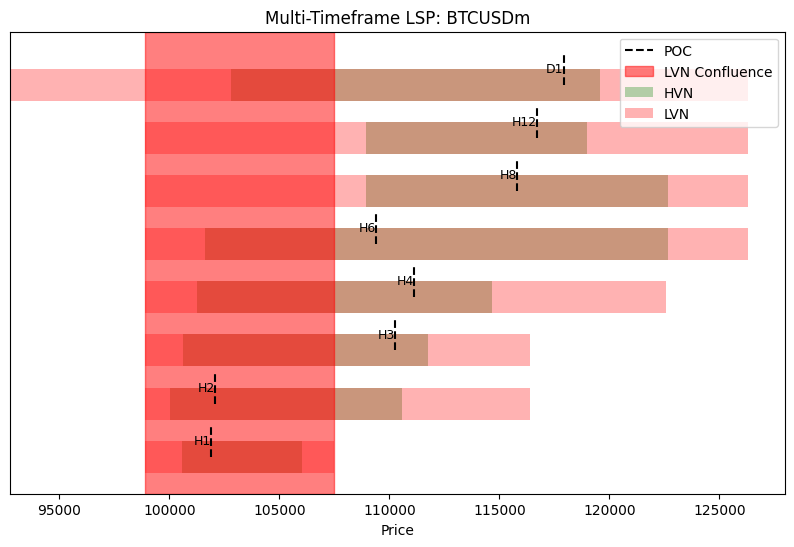

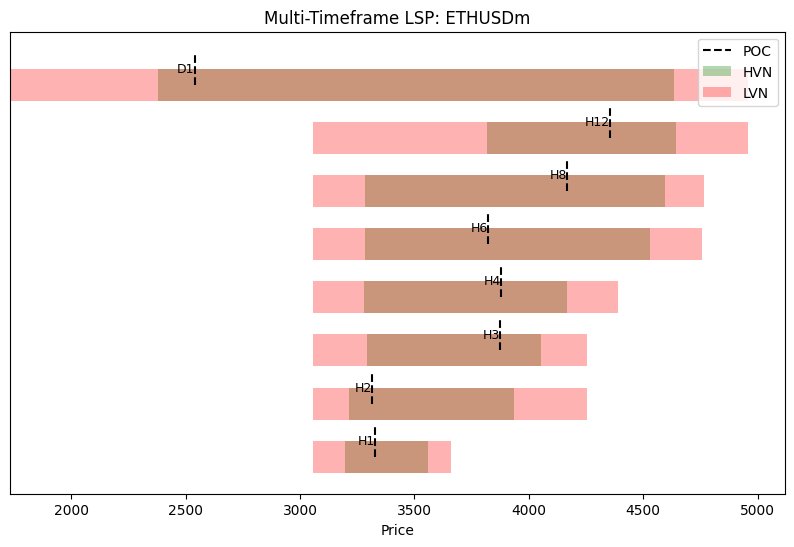

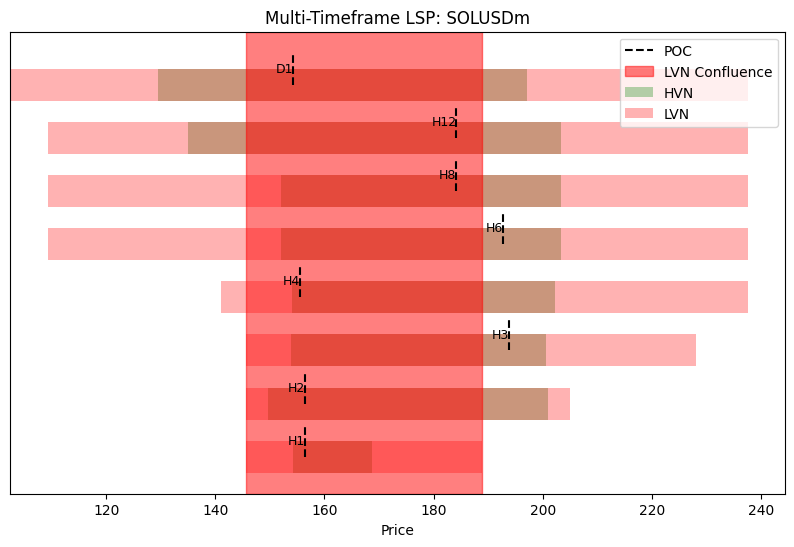

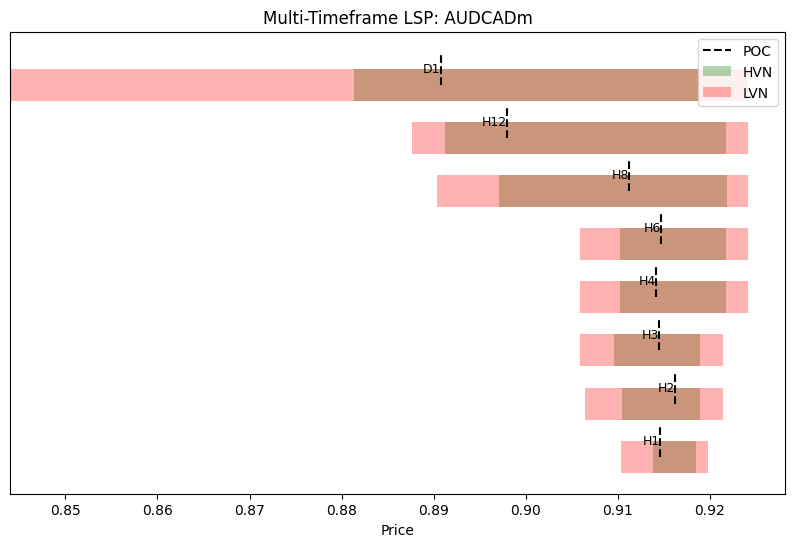

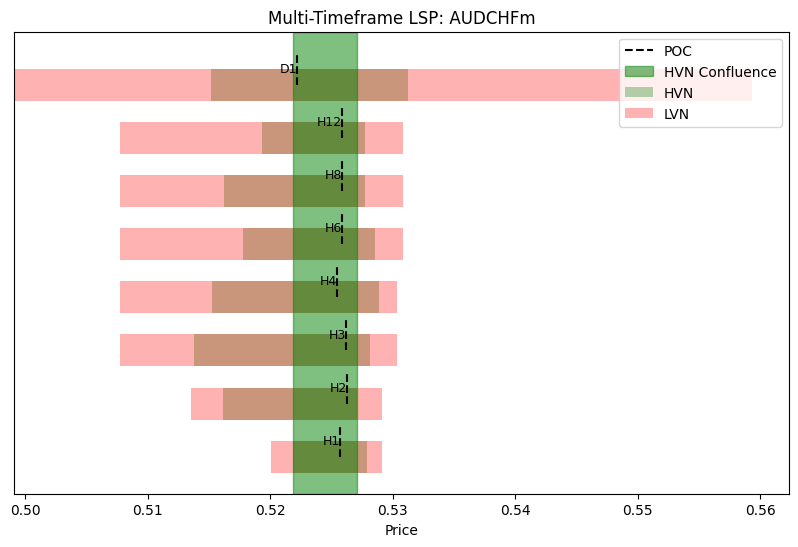

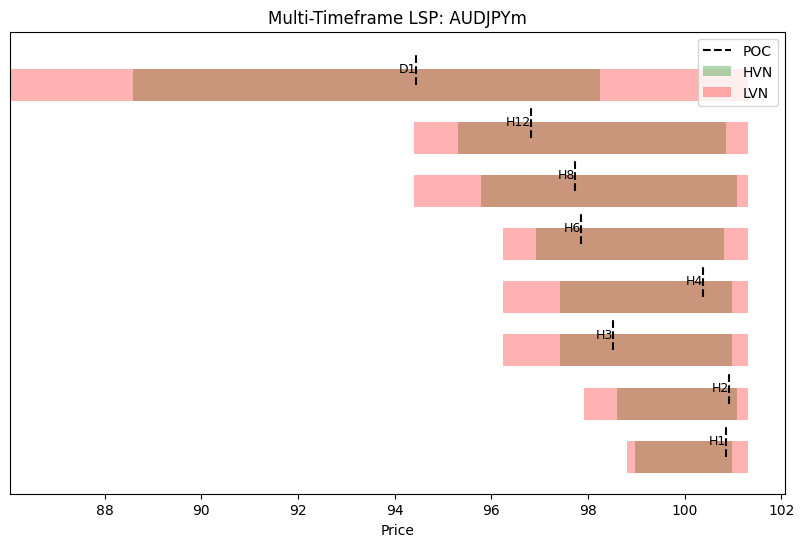

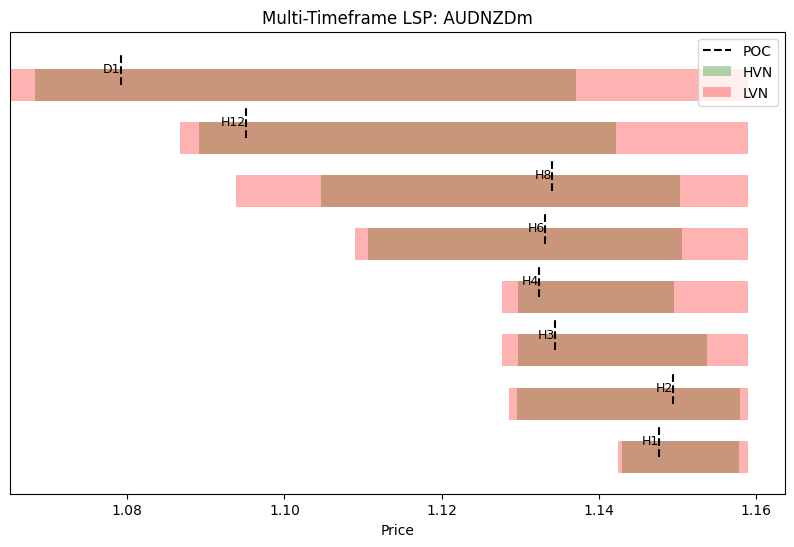

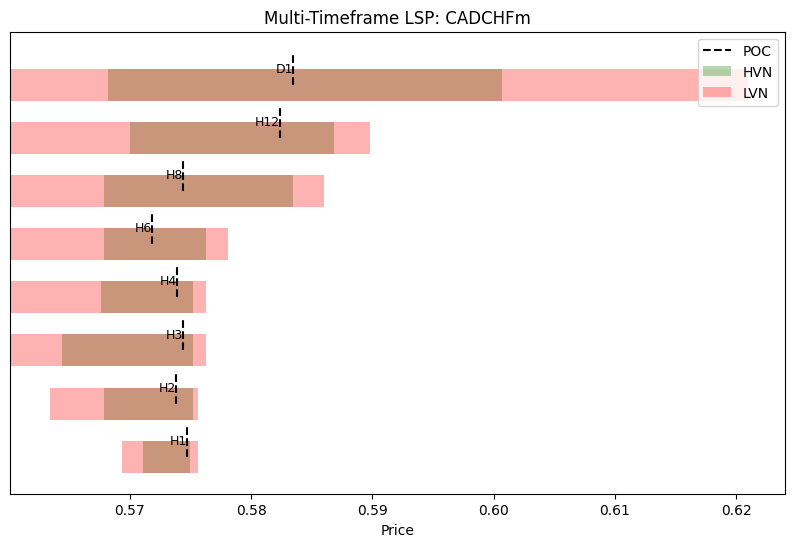

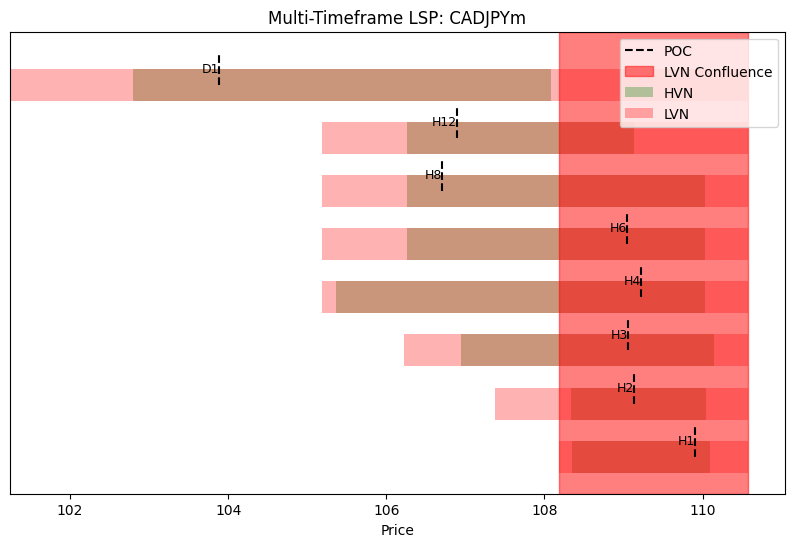

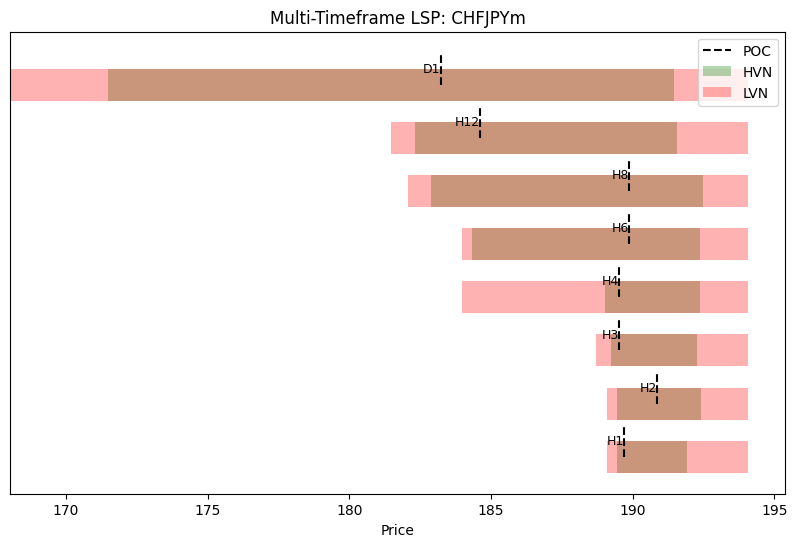

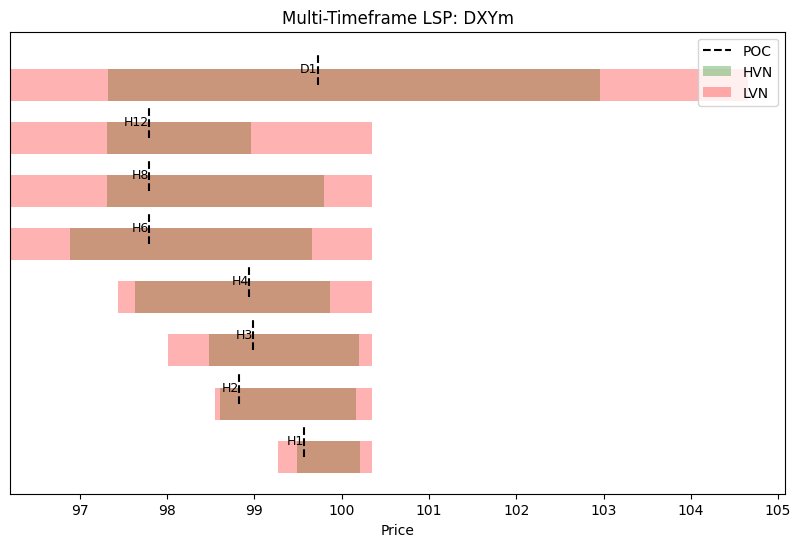

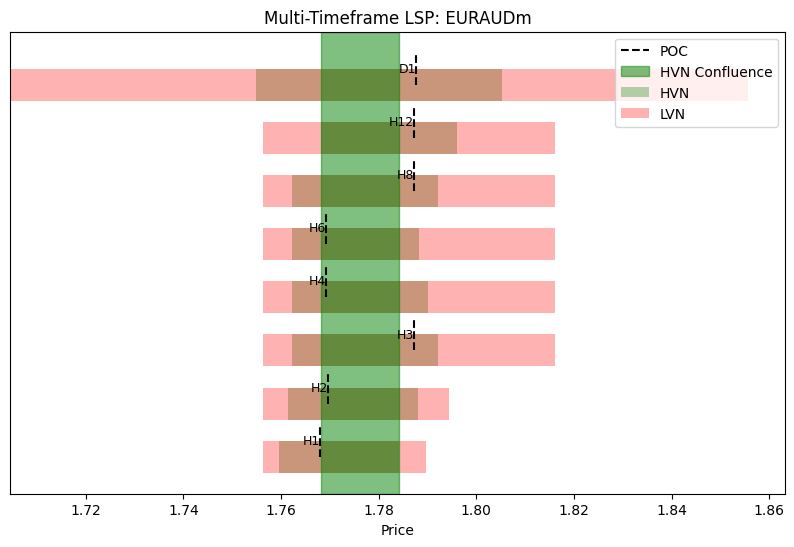

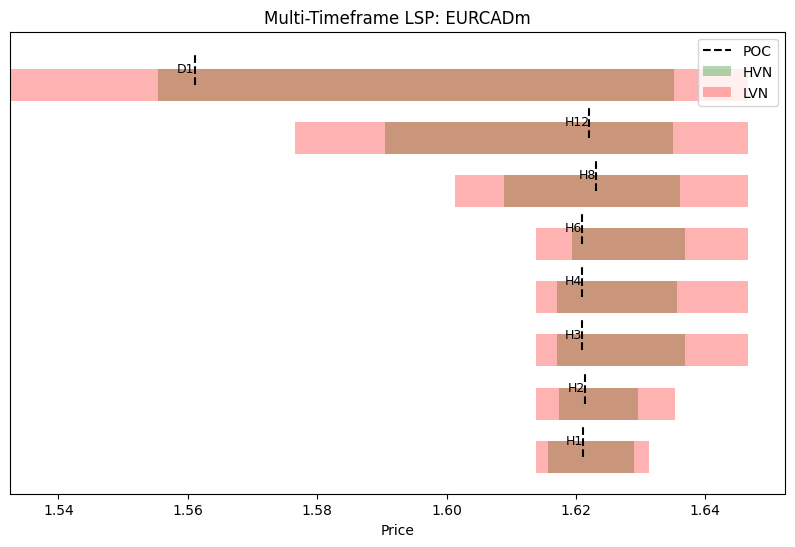

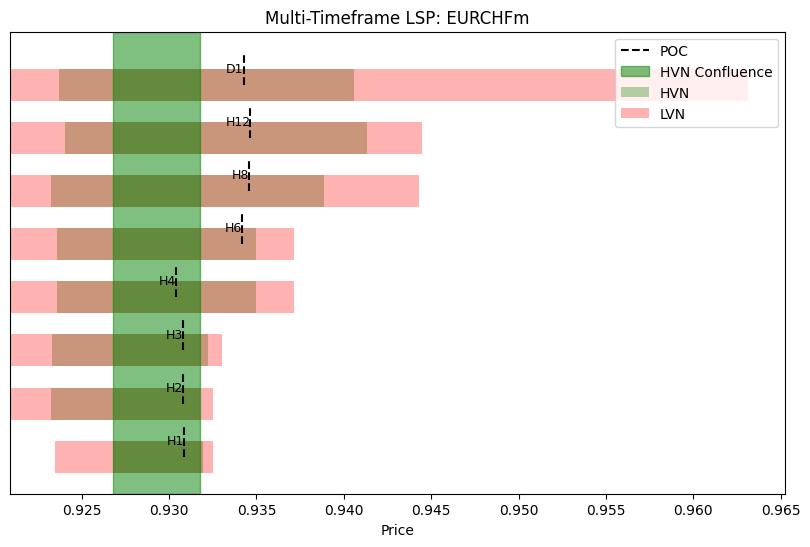

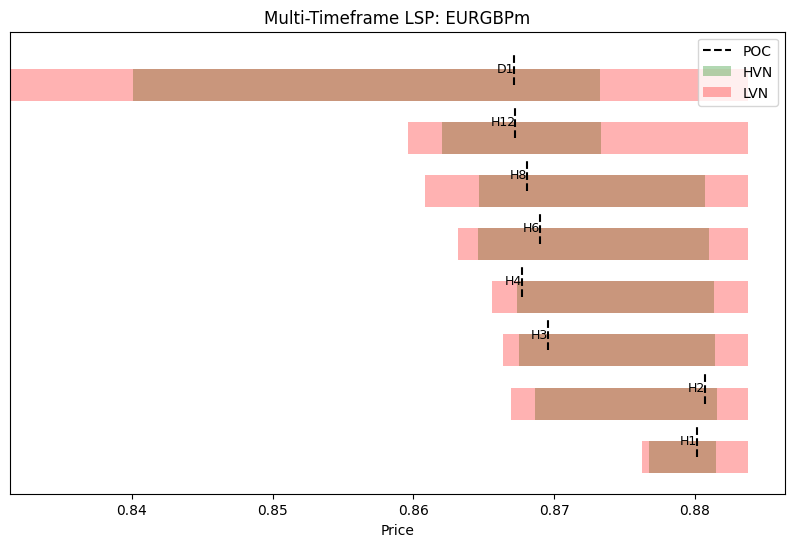

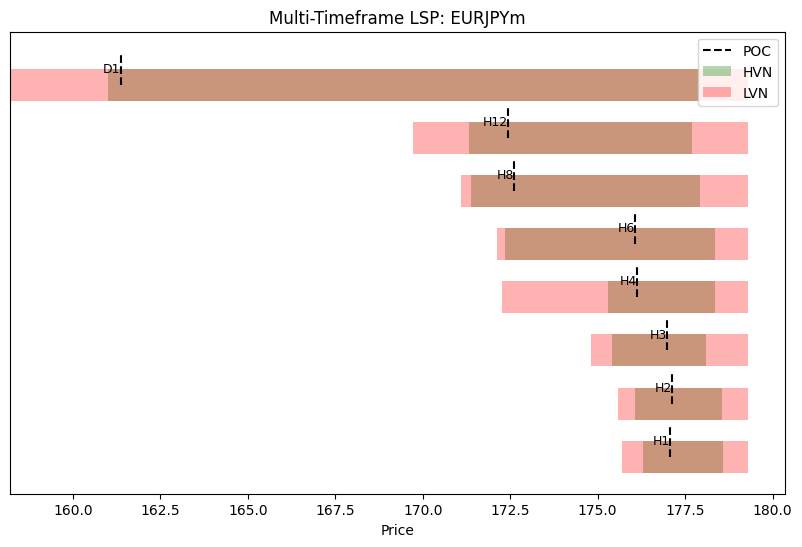

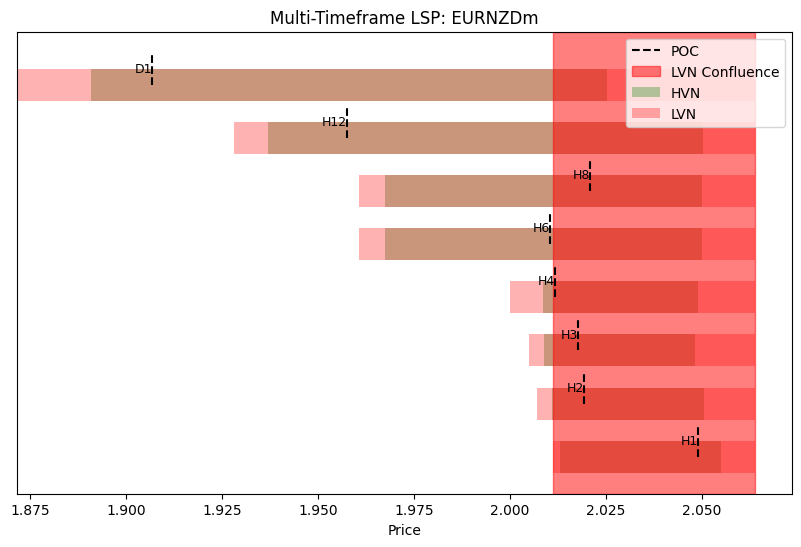

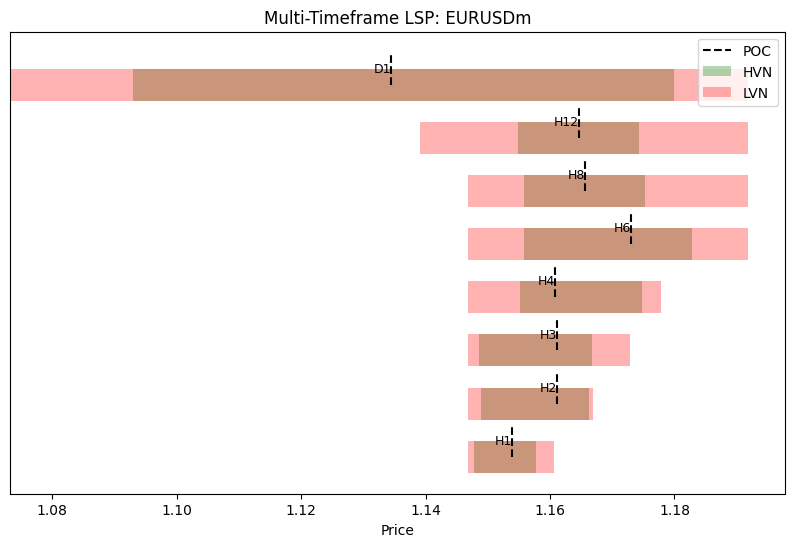

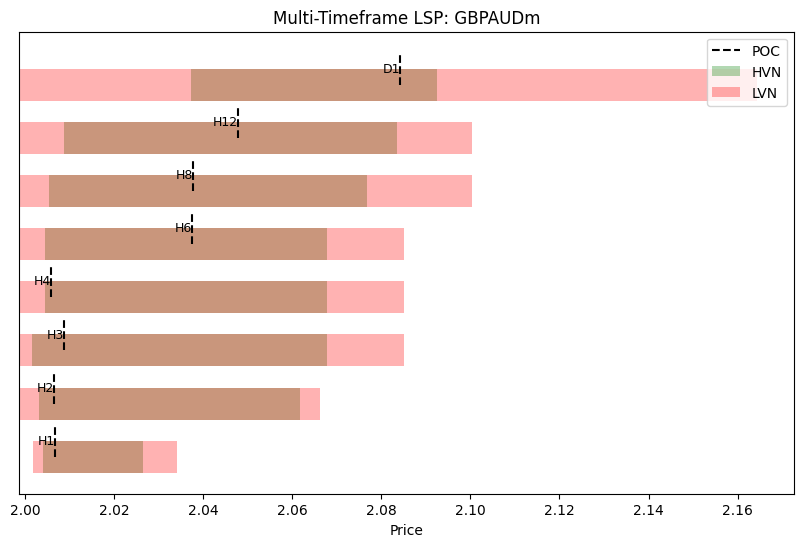

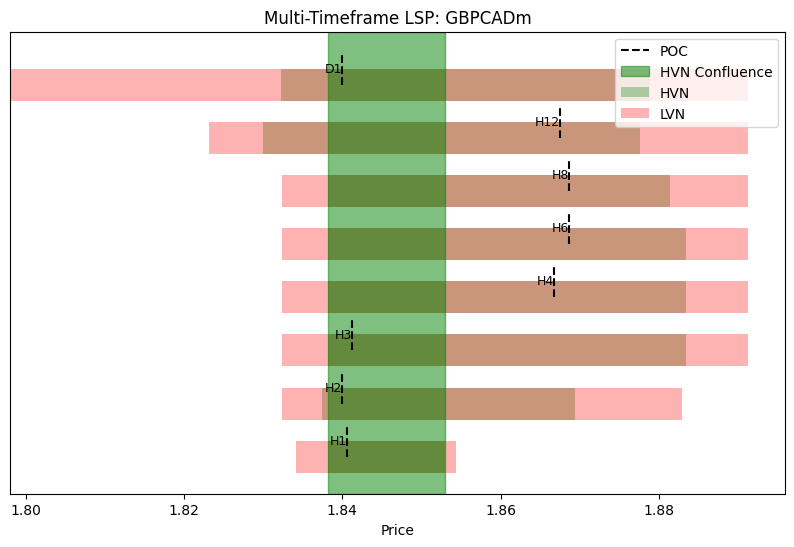

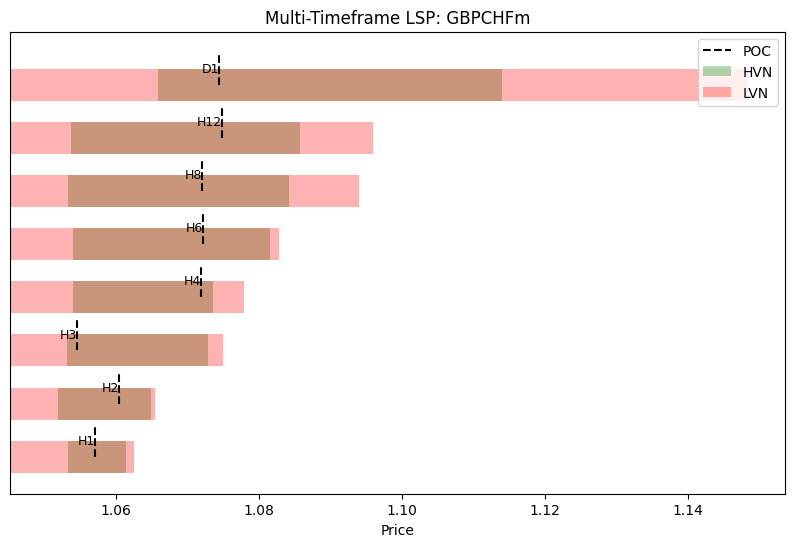

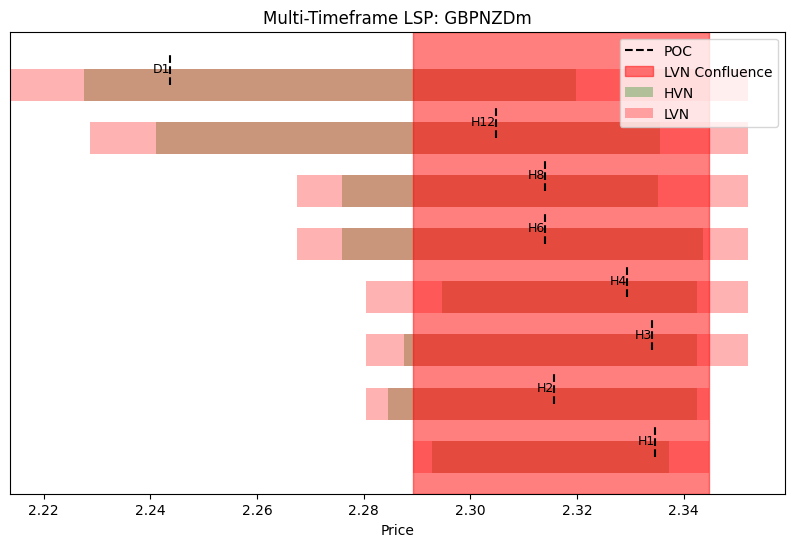

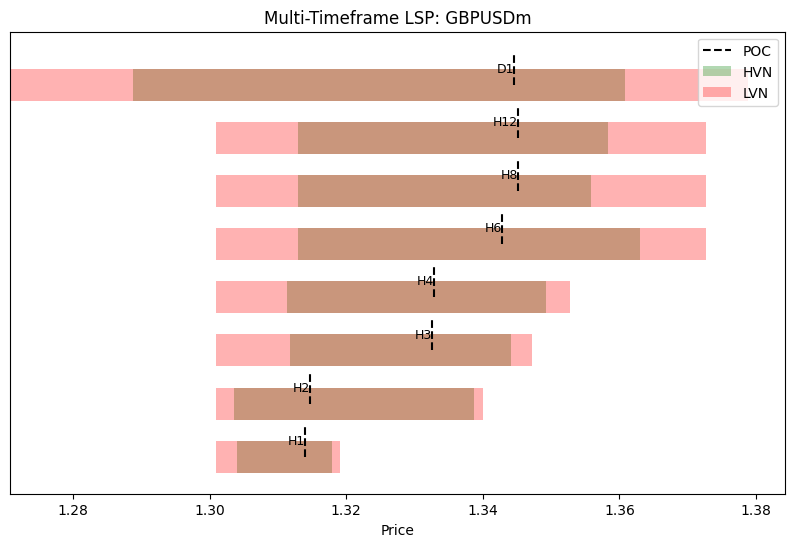

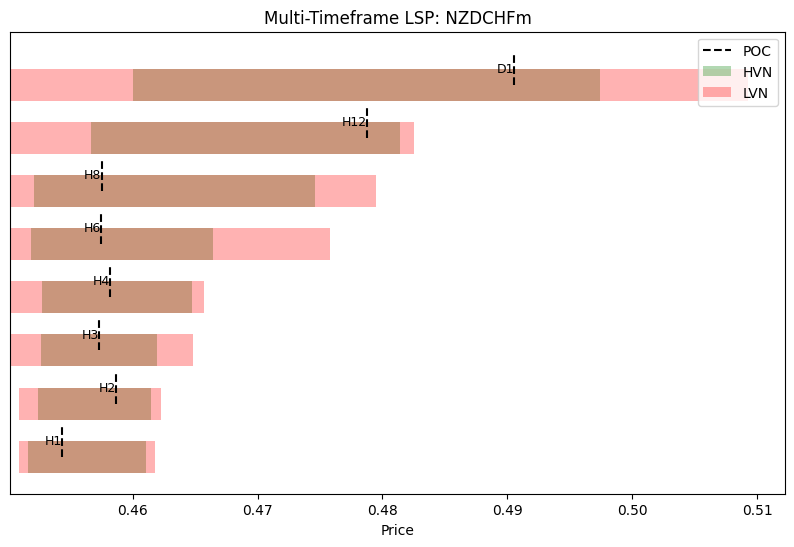

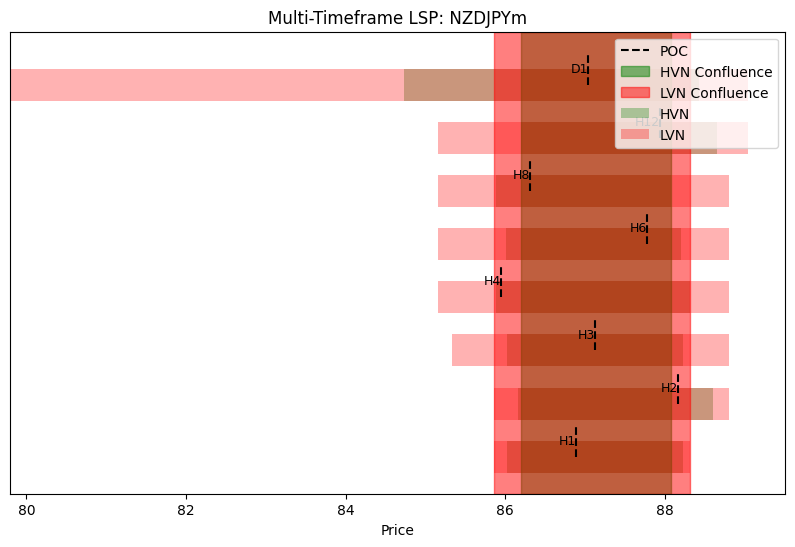

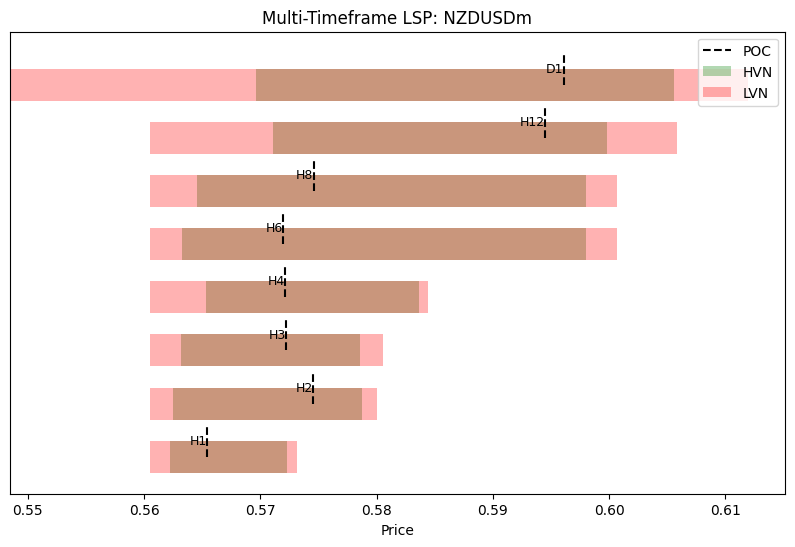

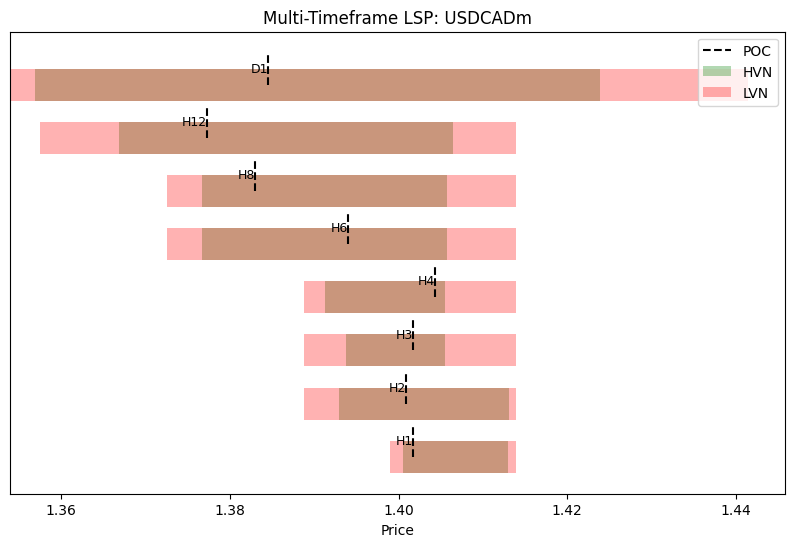

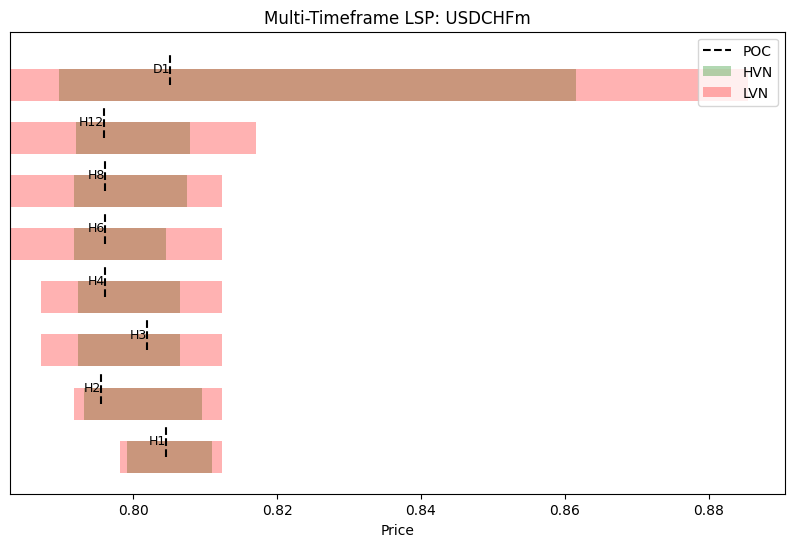

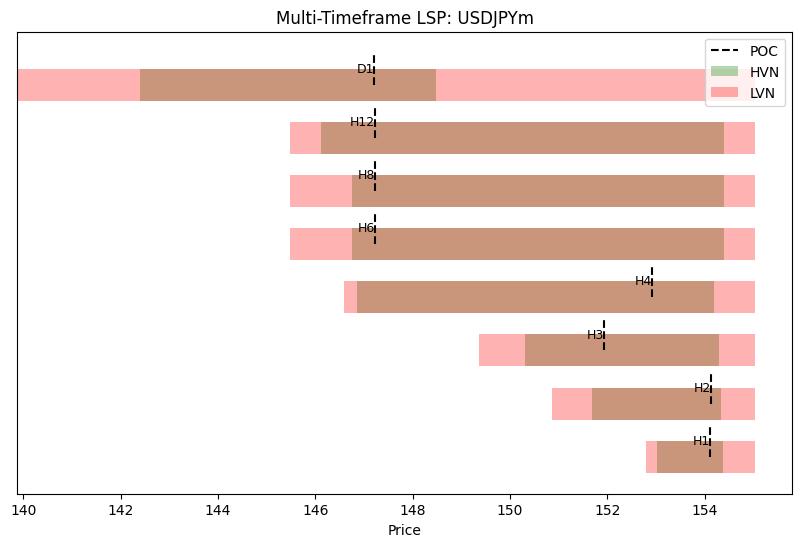

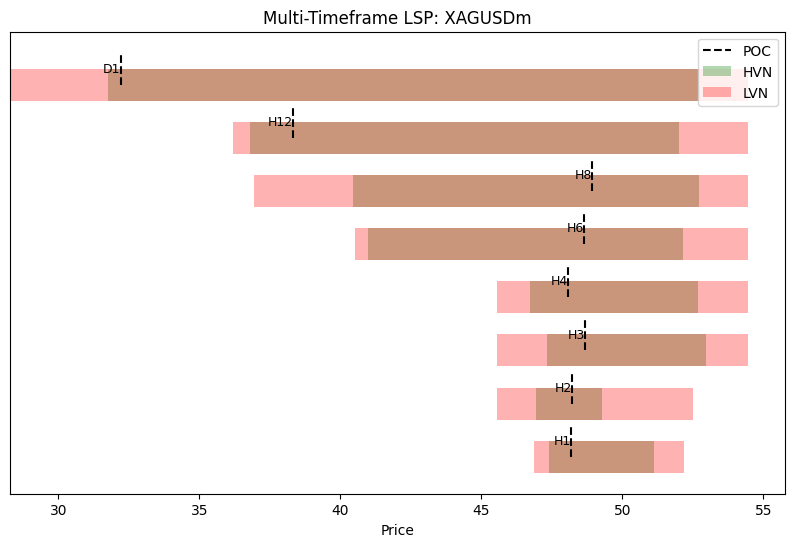

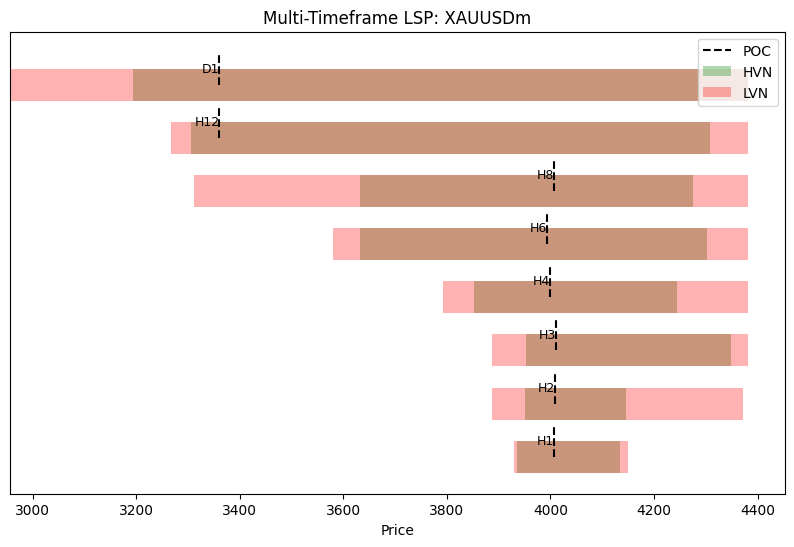

In [99]:
# Example usage
symbols_to_plot = filtered_cfds_symbols # ["DXYm", "EURUSDm", "GBPAUDm"]
timeframes = ["H1", "H2", "H3", "H4", "H6", "H8", "H12", "D1"] # list(timeframes_to_analyze.keys())  

for sym in symbols_to_plot:
    plot_lsp_confluence(sym, symbol_lsp_df, timeframes)

### Lagging Factor

Search for the lagging factors in liquidity rotating pairs  

## Pattern Detection


Up/Down 

Japanese Candlestick 

In [100]:
import pandas as pd
import numpy as np

def label_up_down_bar(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame with columns ['open','high','low','close','volume'] (or at least 'open' and 'close'),
    adds:
      - a column 'label': 'U' if this bar's close > this bar's open; 'D' otherwise
      - a column 'move_pct': (close - open) / open

    Parameters:
        df: pd.DataFrame sorted ascending by time index.

    Returns:
        df2: copy of df with added 'label' and 'move_pct' columns.
    """
    df2 = df.copy()
    df2['move_pct'] = (df2['close'] - df2['open']) / df2['open']
    df2['label'] = np.where(df2['close'] > df2['open'], 'U', 'D')
    return df2

def label_up_down_neutral(
    df: pd.DataFrame,
    threshold: float = 0.0,
    label_equal: str = 'N',
    threshold_frac: bool = False
) -> pd.DataFrame:
    """
    Given a DataFrame with columns ['open','high','low','close', … ],
    adds:
      - a column 'move_pct': (close - open) / open
      - a column 'label' with values:
          'U' if this bar's move_pct > threshold (or close > open + threshold if threshold is absolute),
          'D' if this bar's move_pct < -threshold (or close < open - threshold if threshold is absolute),
          label_equal (default 'N') if |move_pct| ≤ threshold.
    
    Parameters:
        df: pd.DataFrame sorted ascending by time index.
        threshold: if threshold_frac is False, this is an absolute price difference; 
                   if threshold_frac is True, it is a fraction (e.g., 0.002 for 0.2%).
        label_equal: label for neutral bars.
        threshold_frac: bool – whether to treat threshold as fractional (percentage) change.
    
    Returns:
        df2: copy of df with added 'move_pct' and 'label' columns.
    """
    df2 = df.copy()
    df2['move_pct'] = (df2['close'] - df2['open']) / df2['open']
    
    if threshold_frac:
        # threshold is in fraction of open
        df2['label'] = label_equal
        df2.loc[df2['move_pct'] > threshold,  'label'] = 'U'
        df2.loc[df2['move_pct'] < -threshold, 'label'] = 'D'
    else:
        # threshold is absolute price difference
        diff = df2['close'] - df2['open']
        df2['label'] = label_equal
        df2.loc[diff > threshold,  'label'] = 'U'
        df2.loc[diff < -threshold, 'label'] = 'D'
    
    return df2


In [101]:
labeled = label_up_down_bar(df)
labeled

,open,high,low,close,tick_volume,spread,real_volume,volume,move_pct,label
time,,,,,,,,,,
2019-03-01 00:00:00,96.195,96.551,96.061,96.460,65853,0,0,65853,0.002755,U
2019-03-03 00:00:00,96.455,96.455,96.250,96.366,4086,0,0,4086,-0.000923,D
2019-03-04 00:00:00,96.367,96.814,96.367,96.646,59563,0,0,59563,0.002895,U
2019-03-05 00:00:00,96.647,97.012,96.639,96.861,64026,0,0,64026,0.002214,U
2019-03-06 00:00:00,96.861,96.998,96.772,96.824,60656,0,0,60656,-0.000382,D
...,...,...,...,...,...,...,...,...,...,...
2025-11-12 10:00:00,99.607,99.642,99.565,99.598,1449,31,0,1449,-0.000090,D
2025-11-12 11:00:00,99.598,99.633,99.536,99.536,1267,31,0,1267,-0.000623,D
2025-11-12 12:00:00,99.538,99.594,99.522,99.558,1698,31,0,1698,0.000201,U


In [102]:
# e.g., threshold = 0.5 (price units) → only label 'U' or 'D' when close-open >0.5
labeled_n = label_up_down_neutral(df, threshold=0.5)
labeled_n

,open,high,low,close,tick_volume,spread,real_volume,volume,move_pct,label
time,,,,,,,,,,
2019-03-01 00:00:00,96.195,96.551,96.061,96.460,65853,0,0,65853,0.002755,N
2019-03-03 00:00:00,96.455,96.455,96.250,96.366,4086,0,0,4086,-0.000923,N
2019-03-04 00:00:00,96.367,96.814,96.367,96.646,59563,0,0,59563,0.002895,N
2019-03-05 00:00:00,96.647,97.012,96.639,96.861,64026,0,0,64026,0.002214,N
2019-03-06 00:00:00,96.861,96.998,96.772,96.824,60656,0,0,60656,-0.000382,N
...,...,...,...,...,...,...,...,...,...,...
2025-11-12 10:00:00,99.607,99.642,99.565,99.598,1449,31,0,1449,-0.000090,N
2025-11-12 11:00:00,99.598,99.633,99.536,99.536,1267,31,0,1267,-0.000623,N
2025-11-12 12:00:00,99.538,99.594,99.522,99.558,1698,31,0,1698,0.000201,N


In [103]:
import pandas as pd
from typing import List, Tuple

def detect_label_patterns(
    df: pd.DataFrame,
    patterns: List[Tuple[str, ...]],
    label_col: str = 'label',
    min_move_pct: float = None
) -> pd.DataFrame:
    """
    Scans through df and marks occurrences of specified label-sequences (patterns).
    Returns the original df plus a new column 'matched_pattern' which is either None or
    the pattern tuple that matched ending at that row.

    Parameters:
        df: DataFrame sorted ascending by time index, with column `label_col`.
        patterns: list of tuples of labels to detect, e.g., [('U','D','U'), ('D','D','U','U')]
        label_col: name of the column containing labels (e.g., 'U','D','N')
        min_move_pct: if provided, only consider rows where absolute move_pct ≥ this value.

    Returns:
        df2: copy of df with new column 'matched_pattern'
    """
    df2 = df.copy()
    df2['matched_pattern'] = None

    # convert to list for faster indexing
    labels = df2[label_col].tolist()

    for pat in patterns:
        pat_len = len(pat)
        # loop through possible end positions
        for i in range(pat_len - 1, len(labels)):
            window = tuple(labels[i-pat_len+1 : i+1])
            if window == pat:
                # check move_pct condition if required
                if min_move_pct is None:
                    df2.at[df2.index[i], 'matched_pattern'] = pat
                else:
                    mp = df2['move_pct'].iat[i]
                    if abs(mp) >= min_move_pct:
                        df2.at[df2.index[i], 'matched_pattern'] = pat

    return df2


In [104]:
patterns_to_find = [('U','D','U'), ('D','U','D'), ('D','U','D','U')]
df2 = detect_label_patterns(labeled, patterns=patterns_to_find, min_move_pct=0.01)

In [105]:
print(df2[df2['matched_pattern'].notna()][['label','move_pct','matched_pattern']])

                    label  move_pct matched_pattern
time                                               
2025-08-01 12:00:00     D -0.011423       (D, U, D)


### Candlestick Patterns


Look for patterns across timeframes, especially reversal patterns.



In [106]:
# !pip install -U https://github.com/twopirllc/pandas-ta.git

# !pip install -U git+https://github.com/xgboosted/pandas-ta-classic

In [107]:
import pandas as pd
import pandas_ta_classic as ta


all_patterns_df = df.ta.cdl_pattern(name="all")
display(all_patterns_df)

,CDL_2CROWS,CDL_3BLACKCROWS,CDL_3INSIDE,CDL_3LINESTRIKE,CDL_3OUTSIDE,CDL_3STARSINSOUTH,CDL_3WHITESOLDIERS,CDL_ABANDONEDBABY,CDL_ADVANCEBLOCK,CDL_BELTHOLD,...,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS
time,,,,,,,,,,,,,,,,,,,,,
2019-03-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-04 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-05 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-06 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-12 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-12 11:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-12 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Filters


Write a function for multi-timeframe pattern analysis
showing the most frequent patterns occuring across different timeframes.
 

Apply the function to different symbols.


In [114]:
import pandas as pd
import pandas_ta_classic as ta
import numpy as np
import logging
from typing import List, Dict, Any

logger = logging.getLogger(__name__)

def analyze_symbols_patterns(
    symbols: List[str],
    timeframes: Dict[str, Any],
    period: int = 100,
    patterns_name: str = "all",
    top_n: int = 5
) -> pd.DataFrame:
    """
    Multi-timeframe candlestick pattern analyzer with “current pattern per timeframe” and
    improved robustness for column naming and single-timeframe cases.

    Parameters
    ----------
    symbols : List[str]
        Symbols/tickers to analyze.
    timeframes : Dict[str, Any]
        Mapping of timeframe label → timeframe code (e.g. {'H1': mt5.TIMEFRAME_H1, 'H4': …}).
    period : int
        Number of bars per timeframe to extract and analyze.
    patterns_name : str or Sequence[str]
        Name(s) passed to `df.ta.cdl_pattern(name=…)`.
    top_n : int
        Number of top patterns (by total count) to report per symbol.

    Returns
    -------
    pd.DataFrame
        Rows = symbols. Columns include:
          - For each pattern: counts (bull, bear, total) + pct of total occurrences
          - A list of top_n patterns per symbol (string)
          - Alignment count: number of bars where same pattern fired in >1 timeframe
          - For each timeframe: “<TF>_current” giving the last formed pattern name + direction or None
    """

    def _extract_pattern_name(col: str, tf_labels: List[str]) -> str:
        """
        Extract the base pattern name from a column name.
        Handles names like "H1_CDL_ENGULFING_bull" or "H1_engulfing_tot".
        Returns a normalized lowercase pattern name.
        """
        parts = col.split("_")
        # Remove timeframe prefix if present
        if parts[0] in tf_labels:
            parts = parts[1:]
        # Now parts[0] might be "CDL" or "CDL<pattern>" or direct pattern name
        first = parts[0]
        if first.upper() == "CDL" and len(parts) >= 2:
            patt = parts[0] + "_" + parts[1]
        elif first.upper().startswith("CDL"):
            patt = first
        else:
            patt = first
        return patt.lower()

    all_symbols_summary: Dict[str, Dict[str, Any]] = {}

    tf_labels = list(timeframes.keys())

    for symbol in symbols:
        logger.info(f"Processing symbol: {symbol}")
        tf_pat_dfs: Dict[str, pd.DataFrame] = {}
        tf_counts: Dict[str, pd.Series]   = {}
        current_patterns: Dict[str, Any]  = {}

        for tf_label, tf_code in timeframes.items():
            try:
                df = get_data_mt5(symbol=symbol, timeframe=tf_code, n_bars=period)
                if df is None or df.empty:
                    logger.warning(f"No data for {symbol} / {tf_label}")
                    continue

                pat_df = df.ta.cdl_pattern(name=patterns_name, append=False)
                tf_pat_dfs[tf_label] = pat_df

                bullish_counts = (pat_df == 100).sum(axis=0)
                bearish_counts = (pat_df == -100).sum(axis=0)
                total_counts   = bullish_counts + bearish_counts

                combined = pd.Series(dtype=int)
                for pat in total_counts.index:
                    combined[f"{tf_label}_{pat}_bull"] = int(bullish_counts[pat])
                    combined[f"{tf_label}_{pat}_bear"] = int(bearish_counts[pat])
                    combined[f"{tf_label}_{pat}_tot"]  = int(total_counts[pat])
                tf_counts[tf_label] = combined

                last_row = pat_df.iloc[-1]
                nonzero = last_row[last_row != 0]
                if not nonzero.empty:
                    pat_name  = nonzero.abs().idxmax()
                    direction = "bull" if last_row[pat_name] > 0 else "bear"
                    current_patterns[f"{tf_label}_current"] = f"{pat_name}_{direction}"
                else:
                    current_patterns[f"{tf_label}_current"] = None

            except Exception as e:
                logger.exception(f"Error for {symbol} / {tf_label}: {e}")
                continue

        if not tf_counts:
            logger.warning(f"No valid pattern data collected for symbol {symbol}")
            continue

        # Combine counts across timeframes
        counts_concat = pd.concat(list(tf_counts.values()), axis=1).fillna(0).astype(int)
        counts_df     = counts_concat.T if hasattr(counts_concat, "T") else counts_concat.to_frame().T

        if isinstance(counts_df, pd.Series):
            counts_df = counts_df.to_frame().T

        base_names = [_extract_pattern_name(col, tf_labels) for col in counts_df.columns]

        agg_data: Dict[str, Dict[str,int]] = {}
        for col, bn in zip(counts_df.columns, base_names):
            if bn not in agg_data:
                agg_data[bn] = {"bull": 0, "bear": 0, "tot": 0}
            if col.endswith("_bull"):
                agg_data[bn]["bull"] += counts_df[col].iloc[0]
            elif col.endswith("_bear"):
                agg_data[bn]["bear"] += counts_df[col].iloc[0]
            elif col.endswith("_tot"):
                agg_data[bn]["tot"]  += counts_df[col].iloc[0]

        agg_df = pd.DataFrame.from_dict(agg_data, orient="index")
        total_occ = agg_df["tot"].sum()
        agg_df["pct_tot"] = np.where(total_occ > 0, agg_df["tot"] / total_occ, 0.0)

        top_patterns = agg_df.sort_values("tot", ascending=False).head(top_n)
        top_list     = list(top_patterns.index)

        common_index = None
        for tf_label, pat_df in tf_pat_dfs.items():
            idx = pat_df.index
            common_index = idx if common_index is None else common_index.intersection(idx)
        alignment_count = 0
        if common_index is not None and len(common_index) > 0:
            for idx in common_index:
                for pat in agg_df.index:
                    count_nonzero = sum(
                        (tf_pat_dfs[tf_l].loc[idx, pat] != 0)
                        for tf_l in tf_pat_dfs if pat in tf_pat_dfs[tf_l].columns
                    )
                    if count_nonzero > 1:
                        alignment_count += 1

        summary: Dict[str, Any] = {}
        for pat, row in agg_df.iterrows():
            summary[f"pat_{pat}_bull"] = int(row["bull"])
            summary[f"pat_{pat}_bear"] = int(row["bear"])
            summary[f"pat_{pat}_tot"]  = int(row["tot"])
            summary[f"pat_{pat}_pct"]  = float(row["pct_tot"])
        summary["top_patterns"]    = top_list
        summary["alignment_count"] = alignment_count
        summary.update(current_patterns)

        all_symbols_summary[symbol] = summary

    final_df = pd.DataFrame.from_dict(all_symbols_summary, orient="index").fillna(0)
    final_df.index.name = "symbol"
    return final_df



In [115]:
symbols_to_analyze = filtered_cfds_symbols # ["BTCUSD", "ETHUSD"]

timeframes_to_analyze = {
    # "M1": mt5.TIMEFRAME_M1,
    # "M2": mt5.TIMEFRAME_M2,
    # "M3": mt5.TIMEFRAME_M3,
    # "M4": mt5.TIMEFRAME_M4,
    # "M5": mt5.TIMEFRAME_M5,
    # "M6": mt5.TIMEFRAME_M6,
    # "M10": mt5.TIMEFRAME_M10,
    # "M12": mt5.TIMEFRAME_M12,
    # "M15": mt5.TIMEFRAME_M15,
    # "M20": mt5.TIMEFRAME_M20,
    # "M30": mt5.TIMEFRAME_M30,
    "H1": mt5.TIMEFRAME_H1,
    "H2": mt5.TIMEFRAME_H2,
    "H3": mt5.TIMEFRAME_H3,
    "H4": mt5.TIMEFRAME_H4,
    "H6": mt5.TIMEFRAME_H6,
    "H8": mt5.TIMEFRAME_H8,
    "H12": mt5.TIMEFRAME_H12,
    "D1": mt5.TIMEFRAME_D1,
}

pattern_counts_df = analyze_symbols_patterns(
    symbols=symbols_to_analyze,
    timeframes=timeframes_to_analyze,
    period=500,
    patterns_name="all",
    top_n=3
)


2025-11-12 15:56:26,053 - INFO - Processing symbol: BTCUSDm


2025-11-12 15:56:33,126 - INFO - Processing symbol: ETHUSDm
2025-11-12 15:56:37,731 - INFO - Processing symbol: SOLUSDm
2025-11-12 15:56:41,742 - INFO - Processing symbol: AUDCADm
2025-11-12 15:56:44,738 - INFO - Processing symbol: AUDCHFm
2025-11-12 15:56:49,799 - INFO - Processing symbol: AUDJPYm
2025-11-12 15:56:52,863 - INFO - Processing symbol: AUDNZDm
2025-11-12 15:56:55,956 - INFO - Processing symbol: CADCHFm
2025-11-12 15:56:59,130 - INFO - Processing symbol: CADJPYm
2025-11-12 15:57:02,051 - INFO - Processing symbol: CHFJPYm
2025-11-12 15:57:05,454 - INFO - Processing symbol: DXYm
2025-11-12 15:57:08,368 - INFO - Processing symbol: EURAUDm
2025-11-12 15:57:11,410 - INFO - Processing symbol: EURCADm
2025-11-12 15:57:14,138 - INFO - Processing symbol: EURCHFm
2025-11-12 15:57:16,625 - INFO - Processing symbol: EURGBPm
2025-11-12 15:57:18,967 - INFO - Processing symbol: EURJPYm
2025-11-12 15:57:21,325 - INFO - Processing symbol: EURNZDm
2025-11-12 15:57:23,896 - INFO - Processing

In [ ]:
pattern_counts_df

,CDL_2CROWS,CDL_3BLACKCROWS,CDL_3INSIDE,CDL_3LINESTRIKE,CDL_3OUTSIDE,CDL_3STARSINSOUTH,CDL_3WHITESOLDIERS,CDL_ABANDONEDBABY,CDL_ADVANCEBLOCK,CDL_BELTHOLD,...,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS
symbol,,,,,,,,,,,,,,,,,,,,,
BTCUSDm,0,1,34,19,230,0,1,0,48,533,...,959,12,1,97,0,0,2,0,0,64
ETHUSDm,0,0,23,9,128,0,0,0,60,531,...,972,8,0,92,0,0,0,0,0,28
SOLUSDm,0,0,35,19,209,0,1,0,62,571,...,867,7,1,85,2,0,1,0,0,72
AUDCADm,0,0,21,17,154,0,5,0,74,570,...,876,14,1,72,3,10,0,1,0,27
AUDCHFm,1,0,15,12,131,0,3,0,59,559,...,854,15,0,92,0,10,0,0,0,20
AUDJPYm,0,1,27,18,190,0,0,0,65,570,...,878,13,0,102,0,4,3,1,0,38
AUDNZDm,0,0,22,15,127,0,3,0,72,512,...,894,8,1,79,0,14,2,0,0,23
CADCHFm,0,0,22,12,138,0,2,0,48,564,...,867,9,1,94,0,17,0,1,0,15
CADJPYm,0,0,32,15,172,0,8,0,63,580,...,845,8,2,82,2,0,2,1,0,30


In [116]:
pattern_counts_df.columns

Index(['pat_cdl_2crows_bull', 'pat_cdl_2crows_bear', 'pat_cdl_2crows_tot',
       'pat_cdl_2crows_pct', 'pat_cdl_3blackcrows_bull',
       'pat_cdl_3blackcrows_bear', 'pat_cdl_3blackcrows_tot',
       'pat_cdl_3blackcrows_pct', 'pat_cdl_3inside_bull',
       'pat_cdl_3inside_bear',
       ...
       'top_patterns', 'alignment_count', 'H1_current', 'H2_current',
       'H3_current', 'H4_current', 'H6_current', 'H8_current', 'H12_current',
       'D1_current'],
      dtype='object', length=258)

In [117]:
pattern_counts_df['top_patterns']

symbol
BTCUSDm       [cdl_spinningtop, cdl_longline, cdl_shortline]
ETHUSDm       [cdl_spinningtop, cdl_shortline, cdl_longline]
SOLUSDm       [cdl_spinningtop, cdl_shortline, cdl_longline]
AUDCADm       [cdl_spinningtop, cdl_longline, cdl_shortline]
AUDCHFm       [cdl_spinningtop, cdl_longline, cdl_shortline]
AUDJPYm       [cdl_spinningtop, cdl_shortline, cdl_longline]
AUDNZDm      [cdl_spinningtop, cdl_doji, cdl_longleggeddoji]
CADCHFm       [cdl_spinningtop, cdl_shortline, cdl_longline]
CADJPYm       [cdl_spinningtop, cdl_shortline, cdl_longline]
CHFJPYm       [cdl_spinningtop, cdl_longline, cdl_shortline]
DXYm          [cdl_spinningtop, cdl_shortline, cdl_longline]
EURAUDm        [cdl_spinningtop, cdl_longline, cdl_belthold]
EURCADm       [cdl_spinningtop, cdl_shortline, cdl_longline]
EURCHFm       [cdl_longline, cdl_spinningtop, cdl_shortline]
EURGBPm    [cdl_spinningtop, cdl_shortline, cdl_longlegge...
EURJPYm            [cdl_spinningtop, cdl_longline, cdl_doji]
EURNZDm       [cd

In [118]:
pattern_counts_df['H1_current']

symbol
BTCUSDm            CDL_HIKKAKE_bear
ETHUSDm            CDL_HIKKAKE_bear
SOLUSDm                           0
AUDCADm                           0
AUDCHFm                           0
AUDJPYm    CDL_CLOSINGMARUBOZU_bear
AUDNZDm          CDL_ENGULFING_bear
CADCHFm        CDL_DOJI_10_0.1_bull
CADJPYm        CDL_SPINNINGTOP_bear
CHFJPYm             CDL_HARAMI_bear
DXYm           CDL_DOJI_10_0.1_bull
EURAUDm                           0
EURCADm           CDL_HIGHWAVE_bull
EURCHFm        CDL_DOJI_10_0.1_bull
EURGBPm           CDL_BELTHOLD_bull
EURJPYm             CDL_HARAMI_bear
EURNZDm                           0
EURUSDm        CDL_DOJI_10_0.1_bull
GBPAUDm        CDL_DOJI_10_0.1_bull
GBPCADm                           0
GBPCHFm           CDL_LONGLINE_bear
GBPNZDm          CDL_ENGULFING_bear
GBPUSDm                           0
NZDCHFm            CDL_HIKKAKE_bear
NZDJPYm    CDL_CLOSINGMARUBOZU_bear
NZDUSDm                           0
USDCADm                           0
USDCHFm        CDL_DO

In [120]:
pattern_counts_df['H2_current']

symbol
BTCUSDm           CDL_BELTHOLD_bear
ETHUSDm                           0
SOLUSDm                           0
AUDCADm    CDL_CLOSINGMARUBOZU_bear
AUDCHFm           CDL_LONGLINE_bear
AUDJPYm    CDL_CLOSINGMARUBOZU_bear
AUDNZDm          CDL_SHORTLINE_bear
CADCHFm        CDL_DOJI_10_0.1_bull
CADJPYm        CDL_SPINNINGTOP_bear
CHFJPYm             CDL_HARAMI_bear
DXYm           CDL_DOJI_10_0.1_bull
EURAUDm    CDL_CLOSINGMARUBOZU_bull
EURCADm           CDL_HIGHWAVE_bull
EURCHFm        CDL_DOJI_10_0.1_bull
EURGBPm           CDL_BELTHOLD_bull
EURJPYm          CDL_SHORTLINE_bear
EURNZDm             CDL_HARAMI_bull
EURUSDm        CDL_DOJI_10_0.1_bull
GBPAUDm        CDL_DOJI_10_0.1_bull
GBPCADm                           0
GBPCHFm                           0
GBPNZDm                           0
GBPUSDm           CDL_3OUTSIDE_bear
NZDCHFm        CDL_SPINNINGTOP_bear
NZDJPYm             CDL_HARAMI_bear
NZDUSDm          CDL_SHORTLINE_bear
USDCADm        CDL_DOJI_10_0.1_bull
USDCHFm        CDL_DO

In [125]:
pattern_counts_df['H4_current']

symbol
BTCUSDm                           0
ETHUSDm             CDL_HARAMI_bear
SOLUSDm             CDL_HARAMI_bear
AUDCADm                           0
AUDCHFm         CDL_HIKKAKEMOD_bear
AUDJPYm                           0
AUDNZDm          CDL_SHORTLINE_bear
CADCHFm        CDL_SPINNINGTOP_bear
CADJPYm                           0
CHFJPYm       CDL_ADVANCEBLOCK_bear
DXYm              CDL_3OUTSIDE_bull
EURAUDm        CDL_DOJI_10_0.1_bull
EURCADm                           0
EURCHFm                           0
EURGBPm    CDL_CLOSINGMARUBOZU_bull
EURJPYm       CDL_ADVANCEBLOCK_bear
EURNZDm             CDL_HAMMER_bull
EURUSDm                           0
GBPAUDm           CDL_BELTHOLD_bear
GBPCADm           CDL_BELTHOLD_bear
GBPCHFm           CDL_LONGLINE_bear
GBPNZDm           CDL_BELTHOLD_bear
GBPUSDm           CDL_3OUTSIDE_bear
NZDCHFm        CDL_SPINNINGTOP_bear
NZDJPYm       CDL_ADVANCEBLOCK_bear
NZDUSDm        CDL_DOJI_10_0.1_bull
USDCADm        CDL_DOJI_10_0.1_bull
USDCHFm              

In [124]:
pattern_counts_df['H6_current']

symbol
BTCUSDm                           0
ETHUSDm                           0
SOLUSDm             CDL_HARAMI_bear
AUDCADm                           0
AUDCHFm            CDL_HIKKAKE_bear
AUDJPYm       CDL_ADVANCEBLOCK_bear
AUDNZDm          CDL_ENGULFING_bear
CADCHFm        CDL_SPINNINGTOP_bear
CADJPYm       CDL_ADVANCEBLOCK_bear
CHFJPYm     CDL_STALLEDPATTERN_bear
DXYm              CDL_BELTHOLD_bull
EURAUDm        CDL_DOJI_10_0.1_bull
EURCADm                           0
EURCHFm                           0
EURGBPm    CDL_CLOSINGMARUBOZU_bull
EURJPYm        CDL_DOJI_10_0.1_bull
EURNZDm             CDL_HAMMER_bull
EURUSDm                           0
GBPAUDm           CDL_BELTHOLD_bear
GBPCADm           CDL_BELTHOLD_bear
GBPCHFm           CDL_BELTHOLD_bear
GBPNZDm           CDL_BELTHOLD_bear
GBPUSDm           CDL_BELTHOLD_bear
NZDCHFm        CDL_SPINNINGTOP_bear
NZDJPYm       CDL_ADVANCEBLOCK_bear
NZDUSDm        CDL_DOJI_10_0.1_bull
USDCADm        CDL_DOJI_10_0.1_bull
USDCHFm              

In [123]:
pattern_counts_df['H8_current']

symbol
BTCUSDm            CDL_HIKKAKE_bear
ETHUSDm            CDL_3INSIDE_bull
SOLUSDm           CDL_BELTHOLD_bull
AUDCADm        CDL_DOJI_10_0.1_bull
AUDCHFm          CDL_SHORTLINE_bear
AUDJPYm       CDL_SHOOTINGSTAR_bear
AUDNZDm                           0
CADCHFm            CDL_HIKKAKE_bear
CADJPYm          CDL_SHORTLINE_bull
CHFJPYm           CDL_BELTHOLD_bull
DXYm                              0
EURAUDm        CDL_DOJI_10_0.1_bull
EURCADm     CDL_LONGLEGGEDDOJI_bull
EURCHFm           CDL_BELTHOLD_bear
EURGBPm    CDL_CLOSINGMARUBOZU_bull
EURJPYm          CDL_SHORTLINE_bull
EURNZDm                           0
EURUSDm                           0
GBPAUDm                           0
GBPCADm                           0
GBPCHFm                           0
GBPNZDm                           0
GBPUSDm           CDL_LONGLINE_bear
NZDCHFm            CDL_HIKKAKE_bear
NZDJPYm          CDL_SHORTLINE_bull
NZDUSDm        CDL_DOJI_10_0.1_bull
USDCADm          CDL_ENGULFING_bull
USDCHFm            CD

In [121]:
pattern_counts_df['H12_current']

symbol
BTCUSDm         CDL_HIKKAKE_bear
ETHUSDm          CDL_HARAMI_bear
SOLUSDm          CDL_HARAMI_bear
AUDCADm       CDL_SHORTLINE_bear
AUDCHFm         CDL_HIKKAKE_bull
AUDJPYm     CDL_DOJI_10_0.1_bull
AUDNZDm       CDL_SHORTLINE_bear
CADCHFm     CDL_SPINNINGTOP_bear
CADJPYm       CDL_SHORTLINE_bull
CHFJPYm                        0
DXYm       CDL_SHOOTINGSTAR_bear
EURAUDm        CDL_3OUTSIDE_bear
EURCADm                        0
EURCHFm       CDL_SHORTLINE_bear
EURGBPm        CDL_BELTHOLD_bull
EURJPYm     CDL_DOJI_10_0.1_bull
EURNZDm          CDL_HAMMER_bull
EURUSDm                        0
GBPAUDm        CDL_BELTHOLD_bear
GBPCADm        CDL_BELTHOLD_bear
GBPCHFm        CDL_BELTHOLD_bear
GBPNZDm        CDL_BELTHOLD_bear
GBPUSDm        CDL_BELTHOLD_bear
NZDCHFm     CDL_DOJI_10_0.1_bull
NZDJPYm       CDL_SHORTLINE_bull
NZDUSDm     CDL_DOJI_10_0.1_bull
USDCADm     CDL_DOJI_10_0.1_bull
USDCHFm         CDL_HIKKAKE_bull
USDJPYm        CDL_3OUTSIDE_bull
XAGUSDm        CDL_BELTHOLD_bull
XAU

In [122]:
pattern_counts_df['D1_current']

symbol
BTCUSDm             CDL_HARAMI_bull
ETHUSDm             CDL_HARAMI_bull
SOLUSDm             CDL_HARAMI_bull
AUDCADm        CDL_SPINNINGTOP_bull
AUDCHFm          CDL_SHORTLINE_bear
AUDJPYm           CDL_BELTHOLD_bull
AUDNZDm        CDL_DOJI_10_0.1_bull
CADCHFm                           0
CADJPYm           CDL_BELTHOLD_bull
CHFJPYm           CDL_BELTHOLD_bull
DXYm              CDL_BELTHOLD_bull
EURAUDm          CDL_SHORTLINE_bear
EURCADm             CDL_HARAMI_bear
EURCHFm           CDL_BELTHOLD_bear
EURGBPm    CDL_CLOSINGMARUBOZU_bull
EURJPYm           CDL_BELTHOLD_bull
EURNZDm          CDL_ENGULFING_bear
EURUSDm             CDL_HARAMI_bear
GBPAUDm           CDL_LONGLINE_bear
GBPCADm           CDL_BELTHOLD_bear
GBPCHFm           CDL_BELTHOLD_bear
GBPNZDm                           0
GBPUSDm           CDL_BELTHOLD_bear
NZDCHFm            CDL_HIKKAKE_bear
NZDJPYm           CDL_BELTHOLD_bull
NZDUSDm        CDL_DOJI_10_0.1_bull
USDCADm        CDL_DOJI_10_0.1_bull
USDCHFm          CDL_

## Shutdown

In [ ]:
mt5.shutdown()

True